# The Impacts of Covid-19 on Airbnb in London: Risks and Opportunities

## CASA0013: Foundations of Spatial Data Science

### Student Ids: ucfnany, ucfnath, ucfnql0.

### 

### Structure

-  Import libraries

- 1. Loading and reading data

-  2. Pre-processing

-  3. Processing

-  4. Mapping

### Import Libraries

Before everything, import libraries that will be used to run the following code

In [93]:
import os # to find file path
from urllib.parse import urlparse # to parse URLs into components¶
import matplotlib.pyplot as plt # visualisation output, to make figures
import numpy as np # mathematical functions
import pandas as pd # to manipulate and analyse dataframes
from requests import get # to make http request from remote
import geopandas as gpd # to work witgeo-spatial files
import seaborn as sns # # visualisation output, to make figures

### 1. Loading data

#### 1.1 Download remote data

We select four years of Inside Airbnb data of 2019 and 2022 for analysing the impacts of Covid-19. We choose these two years as pre-covid period and post-covid period.

All these data are from gzip compressed files, so extraction is needed.

In [2]:
# set a function for caching data
def cache_data(src: str, dest: str) -> str:
    """
    Downloads and caches a remote file locally.
    
    This will save it locally with the remote files and can check if it already exists, 
    so you don't need to download by yourself and won't do it twice.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
        
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src)  # to combine the components back into a valid URL string
    fn = os.path.split(url.path)[-1]  # Extract the filename
    dfn = os.path.join(dest, fn)  # Destination filename

    if not os.path.isfile(dfn):

        print(f"{dfn} not found, downloading!")

        path = os.path.split(dest)

        if len(path) >= 1 and path[0] != "":
            os.makedirs(os.path.join(*path), exist_ok=True)

        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)

        print("\tDone downloading...")

    else:
        print(f"Found {dfn} locally!")

    return dfn

The function above allows us to combine components for a vaid URL.

For example, if datasets are all from a same website, so the source path will be the same, the only difference is the follwing downloading parts, see code below.

In [3]:
# set the destination directory for data to download in
ddir = os.path.join("data", "insideairbnb")
# source path
spath = "https://orca.casa.ucl.ac.uk/~jreades/data/"

# download Airbnb data in 2019 and 2022, (ab is short as airbnb)
ab19 = pd.read_csv(
    cache_data(spath + "London-2019-11-listings.csv.gz", ddir),
    compression="gzip",
    low_memory=False,
)

# or use the link to download directly

ab22 = pd.read_csv(
    cache_data(
        "http://data.insideairbnb.com/united-kingdom/england/london/2022-09-10/data/listings.csv.gz",
        ddir,
    ),
    compression="gzip",
    low_memory=False,
)

print("Done.")

Found data/insideairbnb/London-2019-11-listings.csv.gz locally!
Found data/insideairbnb/listings.csv.gz locally!
Done.


#### 1.2 Read data

Have a basic overview of data

Here, we set randomly five rows for a quick overview, and check if there are any duplicated rows.

In [4]:
# define a function for basic overview

def overview(df):
    """
    Basic overview of the dataframe.
    
    This can remove the duplicated rows before having an overview. 
    And choosing 5 rows randomly to have a quick view.
    
    Parameters
    ----------
    df: dataframe
    
    """
    print()
    # check if there are duplicate rows and drop them
    if df.duplicated().sum() > 0:
        print(f"There are {df.duplicated().sum()} duplicated rows")
        df.drop_duplicates(inplace=True, ignore_index=True)
        print("These duplicated columns are dropped.")
    else:
        print("There is no duplicated rows.")
    print(f"Data frame is {df.shape[0]:,} rows x {df.shape[1]} columns")
    print("\n")
    
    # check columns and data type
    print("Basic Overview")
    df.info()

    print("\n")
    print("Random rows for a quick view")
    display(df.sample(5))

Overview the data

In [5]:
overview(ab19)


There are 155 duplicated rows
These duplicated columns are dropped.
Data frame is 85,081 rows x 18 columns


Basic Overview
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85081 entries, 0 to 85080
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              85081 non-null  object
 1   name                            85081 non-null  object
 2   host_id                         85081 non-null  object
 3   host_name                       85081 non-null  object
 4   neighbourhood_group             85081 non-null  object
 5   neighbourhood                   85081 non-null  object
 6   latitude                        85081 non-null  object
 7   longitude                       85081 non-null  object
 8   room_type                       85081 non-null  object
 9   price                           85081 non-null  object
 10  minimum_nights                  85081 non

id                                             name   host_id  \
46034   4724561         Q5. HUGE MODERN FLAT NEXT TO TUBE  (Ham)   1674201   
52308  12940570                Studio in zone 1 London. Sleeps 3  71084498   
73592  24207002                   Stylish 1 Bed Flat in Killburn  60400934   
80272  37804847  2 bed penthouse Serviced Apartment, Kensington.  81617302   
54167  23354515  Double Bedroom w/Private Bathroom in Maida Vale   4344715   

         host_name neighbourhood_group           neighbourhood  latitude  \
46034  DC Partners                      Hammersmith and Fulham  51.49004   
52308       Yvonne                                   Southwark  51.49673   
73592      Monique                                      Camden  51.55058   
80272          Jay                      Kensington and Chelsea  51.49405   
54167       Manuel                                 Westminster  51.52615   

      longitude        room_type price minimum_nights number_of_reviews  \
46034   -.22346  Entire home/apt    67              1               160   
52308   -.09916     Private room    85              3                82   
73592   -.20593  Entire home/apt   140              2                 0   
80272   -.18547  Entire home/apt   450              3                 0   
54167   -.19177     Private room    55              2                 4   

      last_review reviews_per_month calculated_host_listings_count  \
46034  2019-03-29              2.74                             24   
52308  2018-08-19              2.14                              1   
73592                                                            1   
80272                                                           36   
54167  2018-06-21               .23                              1   

      availability_365       room_class last_review_timestamp  
46034              208  Entire home/apt     3/29/2019 0:00:00  
52308               42     Private room     8/19/2018 0:00:00  
73592               90  Entire home/apt                        
80272              365  Entire home/apt                        
54167                0     Private room     6/21/2018 0:00:00

In [6]:
overview(ab22)



There is no duplicated rows.
Data frame is 69,351 rows x 75 columns


Basic Overview
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69351 entries, 0 to 69350
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            69351 non-null  int64  
 1   listing_url                                   69351 non-null  object 
 2   scrape_id                                     69351 non-null  int64  
 3   last_scraped                                  69351 non-null  object 
 4   source                                        69351 non-null  object 
 5   name                                          69330 non-null  object 
 6   description                                   67832 non-null  object 
 7   neighborhood_overview                         39964 non-null  object 
 8   picture_url                                   6935

id                            listing_url       scrape_id  \
44437  44450316  https://www.airbnb.com/rooms/44450316  20220910194334   
18165  18775027  https://www.airbnb.com/rooms/18775027  20220910194334   
7310    8465344   https://www.airbnb.com/rooms/8465344  20220910194334   
47861  49557463  https://www.airbnb.com/rooms/49557463  20220910194334   
40747  40394218  https://www.airbnb.com/rooms/40394218  20220910194334   

      last_scraped           source  \
44437   2022-09-11      city scrape   
18165   2022-09-12  previous scrape   
7310    2022-09-11  previous scrape   
47861   2022-09-11      city scrape   
40747   2022-09-11  previous scrape   

                                                    name  \
44437      Spacious 3 Bedroom 2 Bath Apartment in Hendon   
18165                                          AJ’s Room   
7310                 Studio in Islington for female only   
47861  Apt   2 - New Modern Studio in Trendy Kentish ...   
40747   Spacious townhouse - best location - Scandi-cool   

                                             description  \
44437  Renovated and decorated to a high standard, mo...   
18165  Sonia's has a huge open plan communal space wi...   
7310   A nice, clean and cozy studio/ 1 bedroom flat ...   
47861  Brand NEW modern and bright apartment situated...   
40747  Great quiet townhouse in exclusive Belgravia, ...   

                                   neighborhood_overview  \
44437  Very peaceful and quiet residential road, lots...   
18165  Staying at Auntie Sonia's you are situated in ...   
7310   This is a very safe and quiet area in Islingto...   
47861  The apartment is located just off the high str...   
40747  Amazing exclusive and quiet neighbourhood with...   

                                             picture_url    host_id  ...  \
44437  https://a0.muscache.com/pictures/eb41bb9a-d3a5...  324419215  ...   
18165  https://a0.muscache.com/pictures/1d4ab197-5f11...  130642696  ...   
7310   https://a0.muscache.com/pictures/107644812/38e...    4189056  ...   
47861  https://a0.muscache.com/pictures/miso/Hosting-...  386905447  ...   
40747  https://a0.muscache.com/pictures/ded654f2-1969...    1246446  ...   

      review_scores_communication review_scores_location review_scores_value  \
44437                        4.89                   4.63                4.48   
18165                        4.93                   4.76                4.93   
7310                         5.00                   5.00                5.00   
47861                        5.00                   4.93                4.80   
40747                        5.00                   4.93                5.00   

      license instant_bookable calculated_host_listings_count  \
44437     NaN                f                              9   
18165     NaN                t                              2   
7310      NaN                f                              1   
47861     NaN                f                             17   
40747     NaN                f                              1   

      calculated_host_listings_count_entire_homes  \
44437                                           9   
18165                                           0   
7310                                            1   
47861                                          17   
40747                                           1   

      calculated_host_listings_count_private_rooms  \
44437                                            0   
18165                                            2   
7310                                             0   
47861                                            0   
40747                                            0   

      calculated_host_listings_count_shared_rooms reviews_per_month  
44437                                           0              1.10  
18165                                           0              1.18  
7310                                            0              0.01

Data in 2019 collcted by November: 85,081 rows.

Data in 2022 collected by November: 69,351rows.



<div class="alert alert-block alert-warning"><b>Possible problem: wrong datatype</b> 
    
There is a problem with the data type: some numeric data is presented as object. These do not match the ones in [Inside Airbnb Data Doctionary](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=1322284596).
We're going to fix this problem in the pre-processing phase.
</div>

### 2. Pre-processing

#### 2.1 Datatype



In [7]:
# To check the distribution of numeric columns and find if there is any outliers or problemetic value

# Creating histograms for all columns with numeric values to check their distributions and again check their datatype.
def numeric_cols_hist(df, width, height):
    """
    To create histograms of all numeric columns in the dataframe.
    
    This can have a look at distributions of the numeric columns and check it the datatype is correct.
    
    Parameters
    ----------
    df: dataframe
    
    width: set width of histograms
    
    height: set height of histograms
    
    """
    print('Here, density of values in each numeric column is shown.')
    cols = df.select_dtypes(include=('number')).columns.to_list()
    df[cols].hist(bins=30, figsize=(width, height))
    plt.show()


In [8]:
# print columns in airbnb 2019
ab19.columns.tolist()

['id',
 'name',
 'host_id',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'room_class',
 'last_review_timestamp']

In [9]:
numeric_cols = ['id',
 'host_id',
 'latitude',
 'longitude',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

In [10]:
# change columns datatype into the right ones

for col in numeric_cols:
    ab19[col] = ab19[col].str.strip()  # str.strip() can remove leading and trailing characters
    ab19[col] = ab19[col].apply(pd.to_numeric)

ab19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85081 entries, 0 to 85080
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              85068 non-null  float64
 1   name                            85081 non-null  object 
 2   host_id                         84912 non-null  float64
 3   host_name                       85081 non-null  object 
 4   neighbourhood_group             85081 non-null  object 
 5   neighbourhood                   85081 non-null  object 
 6   latitude                        84911 non-null  float64
 7   longitude                       84911 non-null  float64
 8   room_type                       85081 non-null  object 
 9   price                           84911 non-null  float64
 10  minimum_nights                  84911 non-null  float64
 11  number_of_reviews               84911 non-null  float64
 12  last_review                     

In [11]:
# select integer columns
int_cols = ['id', 'host_id', 'price', 'minimum_nights','number_of_reviews', 'calculated_host_listings_count', 
           'availability_365']

#for col in int_cols:
#    ab19[col] = ab19[col].astype(int)
# as error shows IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer
# we need to clean the NA values first, some values could be 0 after changing the datatype
ab19 = ab19.dropna()

for col in int_cols:
    ab19[col] = ab19[col].astype(int)

Still need fix some datatype, for example, `id` should be integer instead of float.

Here, density of values in each numeric column is shown.


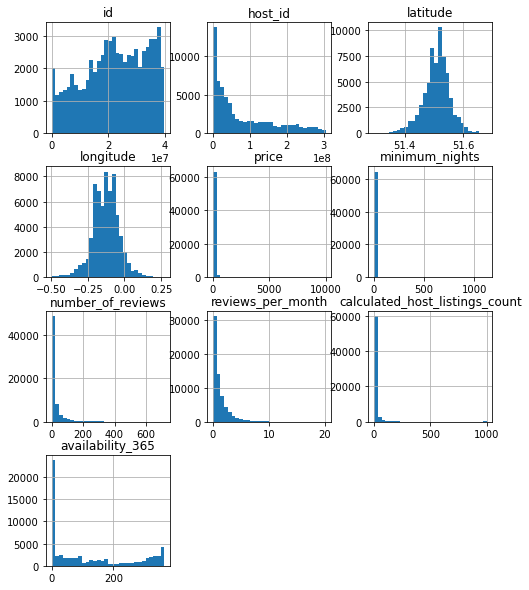

In [12]:
# check the value distributions
numeric_cols_hist(ab19, width=8, height=10)

Seems fine. 

There could be some outliers in column `price`, `minimum_nights`, `number_of_reviews` and the following columns. We will fix this later after choosing the columns we need.

Now the rest three dataframes have wrong datatype showed in `price` column. It should be int.

<div class="alert alert-block alert-warning"><b>Possible problem: ValueError</b> 
    
There is a problem when we wanted to change the datatype of price column, python showed the ValueError: "invalid literal for int() with base 10: '$97.00' " or "Unable to parse string "1,000.00" at position 0".
    
We need two stesp to remove these characters, one for the "$" thing and one for comma. If similar things happen in other column , we can just change the characters and punctuation marks in the function below.
</div>

In [13]:
#ab22['price'] = ab22['price'].astype(int)
#ValueError: invalid literal for int() with base 10: '$97.00'
# and also this error occurs 'Unable to parse string "1,000.00" at position 0'
#so we need to remove the character '$' and the comma ','

def col_to_int(df, col):
    """
    Transform the datatype of price to `int`.
    
    This can remove characters that are leading or tailing the numbers.
    And will remove commas in the string.
    
    Parameters
    ----------
    df: dataframe
    col: 'column name'
    
    """
    df[col] = df[col].str.strip('$') # specific to price column
    df[col] = df[col].str.replace(',', '') #remove comma
    df[col] = df[col].apply(pd.to_numeric) # covert to numeric first
    df[col] = df[col].astype(int)
    df.info() # check
    
col_to_int(ab22, 'price')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69351 entries, 0 to 69350
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            69351 non-null  int64  
 1   listing_url                                   69351 non-null  object 
 2   scrape_id                                     69351 non-null  int64  
 3   last_scraped                                  69351 non-null  object 
 4   source                                        69351 non-null  object 
 5   name                                          69330 non-null  object 
 6   description                                   67832 non-null  object 
 7   neighborhood_overview                         39964 non-null  object 
 8   picture_url                                   69351 non-null  object 
 9   host_id                                       69351 non-null 

Here, density of values in each numeric column is shown.


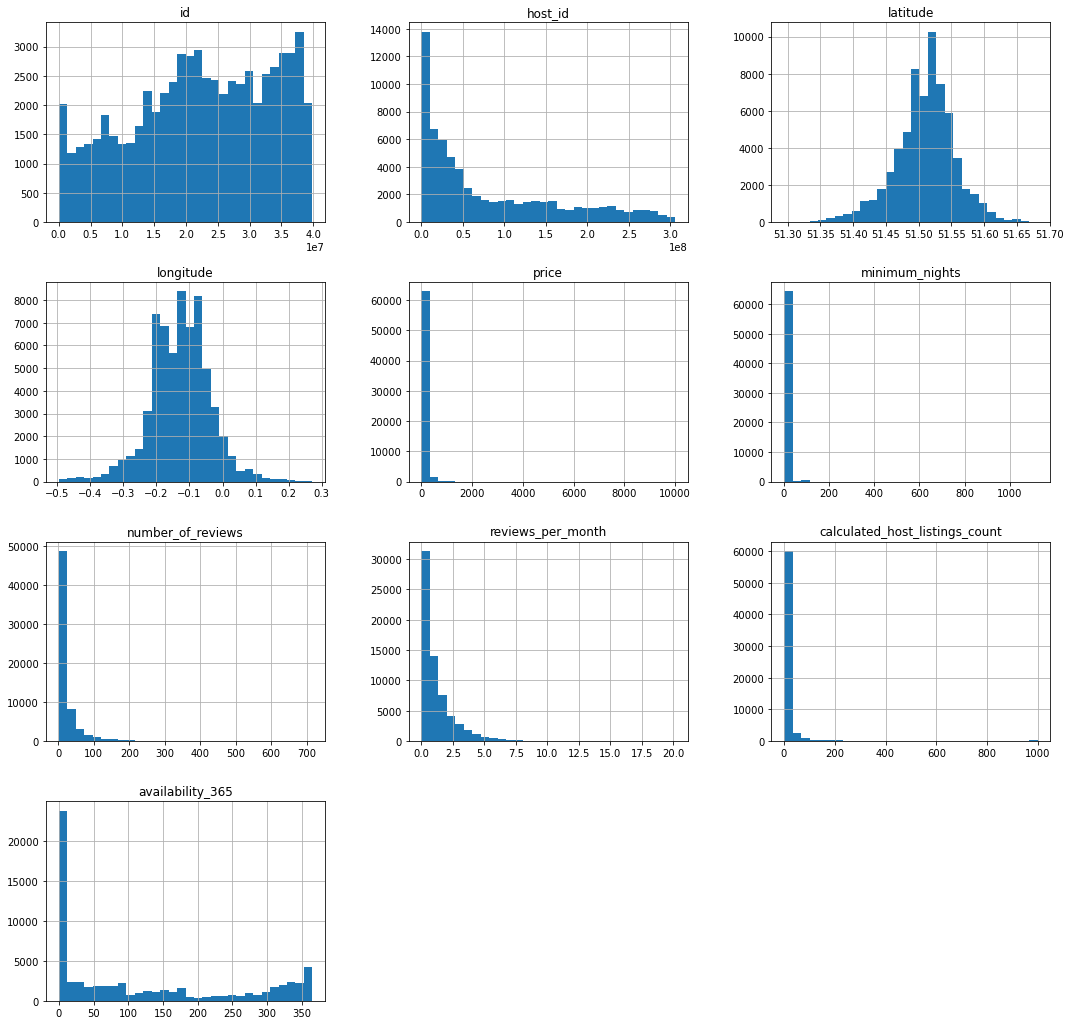

In [14]:
# check the distributions
numeric_cols_hist(ab19, width=18, height=18)

Here, density of values in each numeric column is shown.


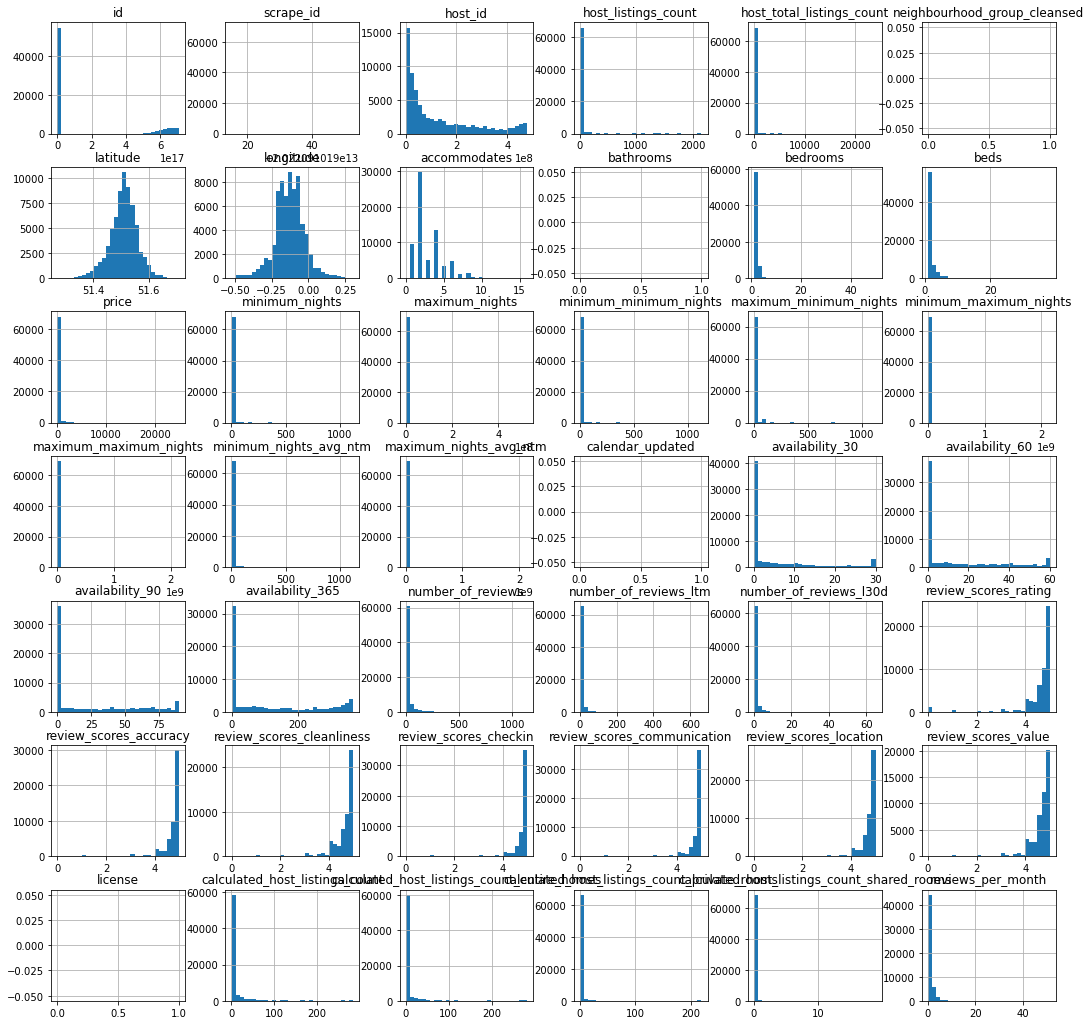

In [15]:
numeric_cols_hist(ab22, width=18, height=18)

#### 2.2 Choosing columns based on our topic

Before continuing our data processing, we're going to select the columns we want first.

We noticed that in `reviews_per_month` from 2019 to 2022 have some empty data values, so we checked the dictionary of this column which refers to "The number of reviews the listing has over the lifetime of the listing". 

Therefore, we can use this as an indicator to define which listings are inactive since they do not have the reviews in the whole year.

In [16]:
ab19.isna().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
room_class                        0
last_review_timestamp             0
dtype: int64

In [17]:
ab22.isna().sum()

id                                                  0
listing_url                                         0
scrape_id                                           0
last_scraped                                        0
source                                              0
                                                ...  
calculated_host_listings_count                      0
calculated_host_listings_count_entire_homes         0
calculated_host_listings_count_private_rooms        0
calculated_host_listings_count_shared_rooms         0
reviews_per_month                               16780
Length: 75, dtype: int64

##### 2.2.1 Drop na values within the column `name`

In [18]:
ab22 = ab22.dropna(subset=['name'])
ab22.isna().sum()

id                                                  0
listing_url                                         0
scrape_id                                           0
last_scraped                                        0
source                                              0
                                                ...  
calculated_host_listings_count                      0
calculated_host_listings_count_entire_homes         0
calculated_host_listings_count_private_rooms        0
calculated_host_listings_count_shared_rooms         0
reviews_per_month                               16766
Length: 75, dtype: int64

##### 2.2.2 Choosing columns

We're going to analyse changes between pre-covid and post-covid. So we select year of 2019 and 2022 to choose columns.

In [19]:
cols_19 = ['id',
 'host_id',
 'neighbourhood',
 'latitude',
 'longitude',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'availability_365']

In the data of 2022, the exact column in borough name should be 'neighbourhood_cleaned'

In [20]:
cols_22 = ['id',
 'host_id',
 'neighbourhood_cleansed',
 'latitude',
 'longitude',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'number_of_reviews_ltm', 
 'last_review',
 'reviews_per_month',
 'availability_365']

In [21]:
# new dataframe of 2019
ab19_new = ab19.loc[:,cols_19]
overview(ab19_new)


There is no duplicated rows.
Data frame is 64,938 rows x 11 columns


Basic Overview
<class 'pandas.core.frame.DataFrame'>
Int64Index: 64938 entries, 0 to 64937
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 64938 non-null  int64  
 1   host_id            64938 non-null  int64  
 2   neighbourhood      64938 non-null  object 
 3   latitude           64938 non-null  float64
 4   longitude          64938 non-null  float64
 5   price              64938 non-null  int64  
 6   minimum_nights     64938 non-null  int64  
 7   number_of_reviews  64938 non-null  int64  
 8   last_review        64938 non-null  object 
 9   reviews_per_month  64938 non-null  float64
 10  availability_365   64938 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 5.9+ MB


Random rows for a quick view


id    host_id           neighbourhood  latitude  longitude  \
41678  28077302  153278823                Lewisham  51.44663    0.01125   
5140   33956336  254582240              Wandsworth  51.44763   -0.20103   
6956   14668206   91119940                   Brent  51.55180   -0.23928   
44223  23125430  130539244                Lewisham  51.43834    0.00425   
57161  21014668  143758259  Kensington and Chelsea  51.51193   -0.19463   

       price  minimum_nights  number_of_reviews last_review  \
41678     60               2                 10  2019-06-26   
5140     200               2                 10  2019-10-31   
6956      36               1                252  2019-10-28   
44223     55               1                 54  2019-05-15   
57161    119               2                  1  2017-11-13   

       reviews_per_month  availability_365  
41678               0.73                77  
5140                2.42                 0  
6956                6.47               342  
44223               2.79                71  
57161               0.04                31

In [22]:
# new dataframe of 2022
ab22_new = ab22.loc[:,cols_22]
overview(ab22_new)


There is no duplicated rows.
Data frame is 69,330 rows x 12 columns


Basic Overview
<class 'pandas.core.frame.DataFrame'>
Int64Index: 69330 entries, 0 to 69350
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      69330 non-null  int64  
 1   host_id                 69330 non-null  int64  
 2   neighbourhood_cleansed  69330 non-null  object 
 3   latitude                69330 non-null  float64
 4   longitude               69330 non-null  float64
 5   price                   69330 non-null  int64  
 6   minimum_nights          69330 non-null  int64  
 7   number_of_reviews       69330 non-null  int64  
 8   number_of_reviews_ltm   69330 non-null  int64  
 9   last_review             52564 non-null  object 
 10  reviews_per_month       52564 non-null  float64
 11  availability_365        69330 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 6.9+ MB



id    host_id neighbourhood_cleansed  latitude  \
4476              6013057     520043                Lambeth  51.46167   
13230            14124148    8908291            Westminster  51.52897   
42214            41996727  332620825                Bromley  51.41501   
56515  597494487075530521   21881808                 Merton  51.42855   
57567  614215903555450183  453130670            Westminster  51.51955   

       longitude  price  minimum_nights  number_of_reviews  \
4476    -0.10574     49               2                 12   
13230   -0.18024     85               8                 11   
42214    0.00313    120               2                  0   
56515   -0.20433    175               3                  2   
57567   -0.14009     80               1                 29   

       number_of_reviews_ltm last_review  reviews_per_month  availability_365  
4476                       0  2018-05-13               0.13                 0  
13230                      3  2021-12-18               0.15                 0  
42214                      0         NaN                NaN                 0  
56515                      2  2022-05-09               0.45                 0  
57567                     29  2022-09-06               6.49               313

Rename the column `neighbourhood_cleansed` to `neighbourhood`, in case for any joins. 

In [23]:
ab22_new.columns = ab22_new.columns.str.replace('neighbourhood_cleansed', 'neighbourhood')
# chenck the column names
ab22_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69330 entries, 0 to 69350
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     69330 non-null  int64  
 1   host_id                69330 non-null  int64  
 2   neighbourhood          69330 non-null  object 
 3   latitude               69330 non-null  float64
 4   longitude              69330 non-null  float64
 5   price                  69330 non-null  int64  
 6   minimum_nights         69330 non-null  int64  
 7   number_of_reviews      69330 non-null  int64  
 8   number_of_reviews_ltm  69330 non-null  int64  
 9   last_review            52564 non-null  object 
 10  reviews_per_month      52564 non-null  float64
 11  availability_365       69330 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 6.9+ MB


### 3 Processing

In this phase, we'll select columns we need and generate dataframes to be analysed.

#### 3.1 Demand Listings/Group data by borough

We will use `number_of_reviews_ltm` (The number of reviews the listing has in the last 12 months) as the indicator which listings are in demand in the short-rental market during that year.

Data of 2019 does not have the column `number_of_reviews_ltm` . And after we checked the date distribution of the last reviews in 2019, we found that the data included reviews left before 2019. So we're going to select reviews activate only in 2019 as the demand listings in 2019.

In [24]:
# change the object datatype into date

In [25]:
date_cols = ['last_review']

array([[<AxesSubplot:title={'center':'last_review'}>]], dtype=object)

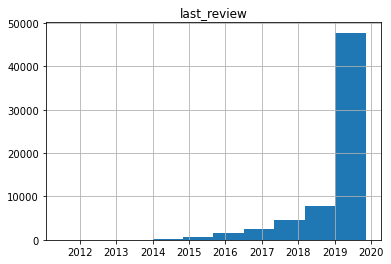

In [26]:
for col in date_cols:
    ab19_new[col] = pd.to_datetime(ab19_new[col])

ab19_new.hist(column = date_cols)

Through the distribution of date, there are some outliers that the dates do not belong with 2019. These listings are not active in 2019, some even not activated since 2014.

As said in the above, we will extract the active ones in 2019.

And the listings in `demand19` are considered active in 2018-Nov to 2019-Nov. However, when compared with activate listings in 2022, some of them could be deactived, or remained.

In [27]:
# 2019 listings was collected on November 2019
# drop last reviews left before 2018-11-01
demand_19 = ab19_new[ab19_new['last_review'].ge('2018-11-01')]
demand_19.sample(5)

id   host_id           neighbourhood  latitude  longitude  price  \
6234   15062700  69377602                  Camden  51.56471   -0.14351     47   
16489  14627193  90802978  Kensington and Chelsea  51.49471   -0.18156    150   
13633   9244494  48043460    Richmond upon Thames  51.47172   -0.28999     65   
40058  21052791   2088548              Wandsworth  51.47122   -0.17415    149   
49367  27954159  99333884  Kensington and Chelsea  51.51936   -0.21193     50   

       minimum_nights  number_of_reviews last_review  reviews_per_month  \
6234                1                207  2019-10-29               5.46   
16489               3                 43  2019-10-17               1.13   
13633               1                123  2019-10-20               3.35   
40058               5                  2  2019-07-09               0.19   
49367               7                  3  2018-12-02               0.22   

       availability_365  
6234                321  
16489                 3  
13633                68  
40058                 7  
49367                 0

In [28]:
demand_19_grouped = demand_19.groupby("neighbourhood")
#list(demand_19_grouped)

In [29]:
# 2022 datatype
for col in date_cols:
    ab22_new[col] = pd.to_datetime(ab22_new[col])

In [30]:
# drop listings do not have reviews in 2022
demand_22 = ab22_new[~(ab22_new['number_of_reviews_ltm'] <= 0)]
demand_22.head()

id  host_id  neighbourhood  latitude  longitude  price  minimum_nights  \
0   13913    54730      Islington  51.56861   -0.11270     50               1   
2  284532  1481412  Tower Hamlets  51.52851   -0.07426     90               5   
4   17402    67564    Westminster  51.52195   -0.14094    379               4   
5  107048   259088      Islington  51.52478   -0.10484    180               4   
6  107051   554519    Westminster  51.52055   -0.18317    204               2   

   number_of_reviews  number_of_reviews_ltm last_review  reviews_per_month  \
0                 30                      9  2022-07-15               0.20   
2                 42                      1  2022-01-04               0.34   
4                 51                      8  2022-09-06               0.36   
5                493                     20  2022-09-02               3.59   
6                581                     66  2022-09-02               4.26   

   availability_365  
0               343  
2               222  
4               249  
5               236  
6               193

In [31]:
demand_22_grouped = demand_22.groupby(by="neighbourhood")

#list(demand_22_grouped)

#### 3.2 Supply listings/Group data by borough

As the data is collected from AirBnb. After removing the NA values, the listings are the supply listings.

In [32]:
supply_19 = ab19_new
supply_22 = ab22_new

In [33]:
supply_19_grouped = supply_19.groupby("neighbourhood")
#list(supply_19_grouped)

In [34]:
supply_22_grouped = supply_22.groupby("neighbourhood")
#list(supply_22_grouped)

#### 3.3 Supply changes in 2019, and 2022

##### Determine the number of listings in each region by looking at how many times each borough appears in the data.

In [35]:
import pandas as pd
number_of_listings_19 = supply_19.value_counts(supply_19['neighbourhood'])
number_of_listings_19

neighbourhood
Westminster               7368
Tower Hamlets             6441
Hackney                   4842
Camden                    4795
Kensington and Chelsea    4390
Islington                 3983
Southwark                 3911
Lambeth                   3895
Hammersmith and Fulham    3276
Wandsworth                3237
Brent                     1955
Lewisham                  1762
Haringey                  1642
Newham                    1460
Ealing                    1321
Greenwich                 1232
Barnet                    1132
Waltham Forest            1074
Merton                     973
Richmond upon Thames       904
Croydon                    800
Hounslow                   744
Redbridge                  499
Bromley                    495
Hillingdon                 470
Enfield                    464
Kingston upon Thames       412
Harrow                     340
City of London             324
Barking and Dagenham       249
Sutton                     216
Havering                 

In [36]:
import pandas as pd
number_of_listings_22= supply_22.value_counts(supply_22['neighbourhood'])
number_of_listings_22

neighbourhood
Westminster               7760
Tower Hamlets             5591
Hackney                   5166
Camden                    4706
Kensington and Chelsea    4612
Southwark                 3966
Islington                 3788
Lambeth                   3717
Wandsworth                3473
Hammersmith and Fulham    2995
Brent                     2068
Lewisham                  2016
Haringey                  1897
Newham                    1681
Barnet                    1611
Ealing                    1553
Greenwich                 1514
Waltham Forest            1322
Merton                    1113
Richmond upon Thames      1108
Hounslow                  1078
Croydon                   1066
Hillingdon                 714
Redbridge                  669
Enfield                    617
Kingston upon Thames       609
Bromley                    593
Harrow                     444
Barking and Dagenham       433
City of London             424
Bexley                     411
Havering                 

In [37]:
# join this two dataframes through neighbourhood name
supply_19_22 = pd.concat([number_of_listings_19, number_of_listings_22], axis = 1)

supply_19_22.columns = ['supply_19', 'supply_22']

supply_19_22

supply_19  supply_22
neighbourhood                               
Westminster                  7368       7760
Tower Hamlets                6441       5591
Hackney                      4842       5166
Camden                       4795       4706
Kensington and Chelsea       4390       4612
Islington                    3983       3788
Southwark                    3911       3966
Lambeth                      3895       3717
Hammersmith and Fulham       3276       2995
Wandsworth                   3237       3473
Brent                        1955       2068
Lewisham                     1762       2016
Haringey                     1642       1897
Newham                       1460       1681
Ealing                       1321       1553
Greenwich                    1232       1514
Barnet                       1132       1611
Waltham Forest               1074       1322
Merton                        973       1113
Richmond upon Thames          904       1108
Croydon                       800       1066
Hounslow                      744       1078
Redbridge                     499        669
Bromley                       495        593
Hillingdon                    470        714
Enfield                       464        617
Kingston upon Thames          412        609
Harrow                        340        444
City of London                324        424
Barking and Dagenham          249        433
Sutton                        216        286
Havering                      173        329
Bexley                        159        411

In [38]:
supply_19_22['change_percent'] = (supply_19_22['supply_22'] - supply_19_22['supply_19']) / supply_19_22['supply_22']

supply_19_22.sort_values(by='change_percent', ascending=False)

supply_19  supply_22  change_percent
neighbourhood                                               
Bexley                        159        411        0.613139
Havering                      173        329        0.474164
Barking and Dagenham          249        433        0.424942
Hillingdon                    470        714        0.341737
Kingston upon Thames          412        609        0.323481
Hounslow                      744       1078        0.309833
Barnet                       1132       1611        0.297331
Redbridge                     499        669        0.254111
Croydon                       800       1066        0.249531
Enfield                       464        617        0.247974
Sutton                        216        286        0.244755
City of London                324        424        0.235849
Harrow                        340        444        0.234234
Waltham Forest               1074       1322        0.187595
Greenwich                    1232       1514        0.186262
Richmond upon Thames          904       1108        0.184116
Bromley                       495        593        0.165261
Ealing                       1321       1553        0.149388
Haringey                     1642       1897        0.134423
Newham                       1460       1681        0.131469
Lewisham                     1762       2016        0.125992
Merton                        973       1113        0.125786
Wandsworth                   3237       3473        0.067953
Hackney                      4842       5166        0.062718
Brent                        1955       2068        0.054642
Westminster                  7368       7760        0.050515
Kensington and Chelsea       4390       4612        0.048135
Southwark                    3911       3966        0.013868
Camden                       4795       4706       -0.018912
Lambeth                      3895       3717       -0.047888
Islington                    3983       3788       -0.051478
Hammersmith and Fulham       3276       2995       -0.093823
Tower Hamlets                6441       5591       -0.152030

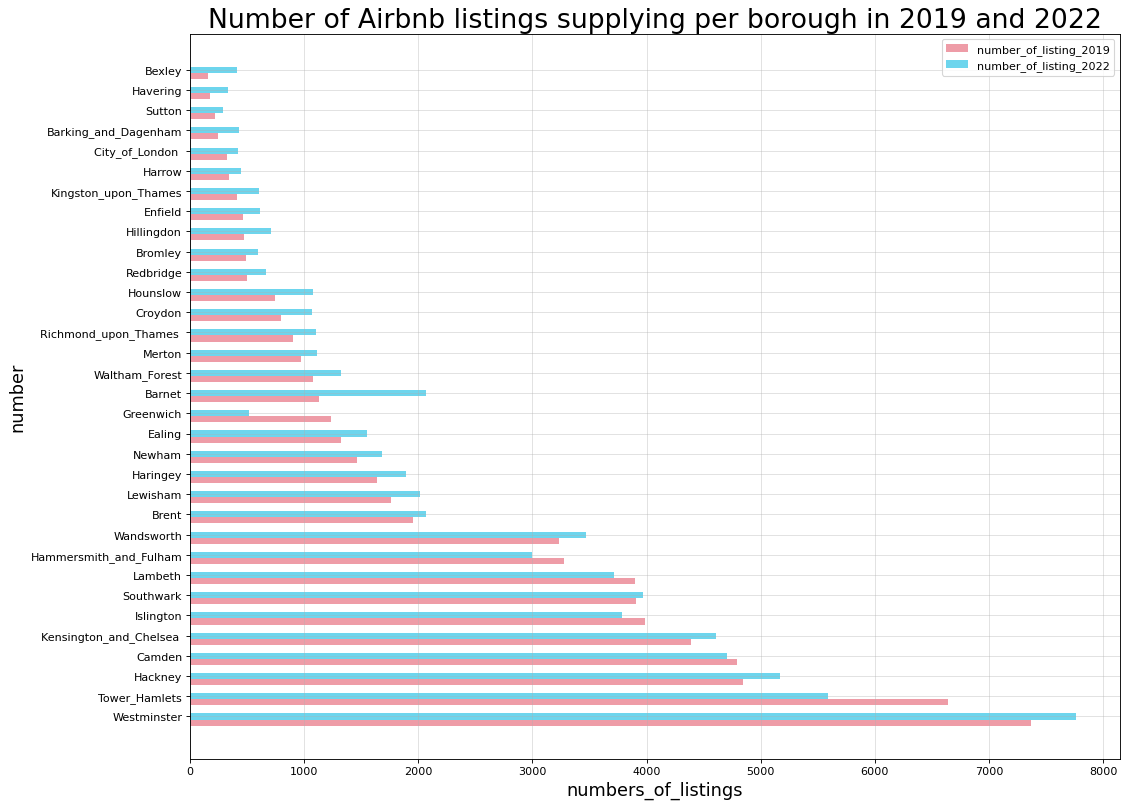

In [39]:
from matplotlib import pyplot as plt
from matplotlib import font_manager



#set figure size
plt.figure(figsize=(15,12),dpi = 80)

#set dataframes
a = ["Westminster","Tower_Hamlets","Hackney","Camden","Kensington_and_Chelsea ","Islington","Southwark"
    ,"Lambeth","Hammersmith_and_Fulham","Wandsworth","Brent","Lewisham","Haringey","Newham","Ealing"
    ,"Greenwich","Barnet","Waltham_Forest","Merton","Richmond_upon_Thames ","Croydon","Hounslow","Redbridge"
    ,"Bromley","Hillingdon","Enfield","Kingston_upon_Thames","Harrow","City_of_London ","Barking_and_Dagenham","Sutton",
     "Havering","Bexley"]
b_1 = [7368,6641,4842,4795,4390,3983,3911,3895,3276,3237,1955,1762,1642,1460,1321,1232,1132,1074,973,904,800,744,499,495,470,464,412,340,324,249,216,173,159]
b_2 = [7760,5591,5166,4706,4612,3788,3966,3717,2995,3473,2068,2016,1897,1681,1553,514,2068,1322,1113,1108,1066,1078,669,593,714,617,609,444,424,433,286,329,411]

height = 0.3
a1 = list(range(len(a)))
a2 = [i+height for i in a1]# Axis Offset
#a3 = [i+height*2 for i in a1]

#plot to check
plt.barh(range(len(a)),b_1,height= height,label = "number_of_listing_2019",color = "#ee9ca7")
plt.barh(a2,b_2,height= height,label = "number_of_listing_2022",color = "#6dd5ed")


#plot grids
plt.grid(alpha = 0.4)

# add lables in y axis 
plt.yticks(a2,a,fontsize = 10)

# add legend
plt.legend()

# add x axis lables and title
plt.xlabel("numbers_of_listings",fontsize = 16)
plt.ylabel("number",fontsize = 16)
plt.title("Number of Airbnb listings supplying per borough in 2019 and 2022",fontsize = 24)

#plot to check
plt.show()



#### 3.4 Demand changes in 2019, and 2022

##### Determine the number of listings in each region

In [40]:
number_19 = demand_19.value_counts(demand_19['neighbourhood'])
number_19.shape[0]

33

In [41]:
number_19

neighbourhood
Westminster               6262
Tower Hamlets             4840
Camden                    3891
Kensington and Chelsea    3591
Hackney                   3328
Southwark                 2950
Lambeth                   2936
Islington                 2912
Hammersmith and Fulham    2565
Wandsworth                2400
Brent                     1552
Lewisham                  1232
Haringey                  1182
Newham                    1170
Ealing                    1004
Greenwich                  945
Barnet                     901
Waltham Forest             805
Merton                     712
Richmond upon Thames       678
Croydon                    633
Hounslow                   588
Redbridge                  396
Hillingdon                 395
Bromley                    379
Enfield                    361
Kingston upon Thames       317
City of London             272
Harrow                     264
Barking and Dagenham       205
Sutton                     166
Havering                 

In [42]:
number_22= supply_22.value_counts(demand_22['neighbourhood'])
number_22.shape[0]

33

Possible problem: Series cannot be merged.

Here, the datatype of counts for each borough is series, thus we cannot use `pd.merge`, instead, we used `pd.concat` to generate a new dataframe of the demand counts of boroughs. 

And when renaming this core dataframes, just use `df.columns = ['col_name']` rather than `df.rename` (not working).

In [43]:
# join this two dataframes through neighbourhood name
demand_19_22 = pd.concat([number_19, number_22], axis = 1)

demand_19_22.columns = ['demands_19', 'demands_22']

demand_19_22

demands_19  demands_22
neighbourhood                                 
Westminster                   6262        3992
Tower Hamlets                 4840        2130
Camden                        3891        2447
Kensington and Chelsea        3591        2375
Hackney                       3328        1880
Southwark                     2950        1675
Lambeth                       2936        1559
Islington                     2912        1454
Hammersmith and Fulham        2565        1345
Wandsworth                    2400        1468
Brent                         1552         987
Lewisham                      1232         814
Haringey                      1182         770
Newham                        1170         737
Ealing                        1004         710
Greenwich                      945         726
Barnet                         901         708
Waltham Forest                 805         574
Merton                         712         479
Richmond upon Thames           678         564
Croydon                        633         550
Hounslow                       588         546
Redbridge                      396         319
Hillingdon                     395         401
Bromley                        379         284
Enfield                        361         340
Kingston upon Thames           317         302
City of London                 272         242
Harrow                         264         215
Barking and Dagenham           205         209
Sutton                         166         131
Havering                       133         174
Bexley                         115         216

In [44]:
demand_19_22['change_percent'] = (demand_19_22['demands_22'] - demand_19_22['demands_19']) / demand_19_22['demands_22']

demand_19_22.sort_values(by='change_percent', ascending=False)

demands_19  demands_22  change_percent
neighbourhood                                                 
Bexley                         115         216        0.467593
Havering                       133         174        0.235632
Barking and Dagenham           205         209        0.019139
Hillingdon                     395         401        0.014963
Kingston upon Thames           317         302       -0.049669
Enfield                        361         340       -0.061765
Hounslow                       588         546       -0.076923
City of London                 272         242       -0.123967
Croydon                        633         550       -0.150909
Richmond upon Thames           678         564       -0.202128
Harrow                         264         215       -0.227907
Redbridge                      396         319       -0.241379
Sutton                         166         131       -0.267176
Barnet                         901         708       -0.272599
Greenwich                      945         726       -0.301653
Bromley                        379         284       -0.334507
Waltham Forest                 805         574       -0.402439
Ealing                        1004         710       -0.414085
Merton                         712         479       -0.486430
Kensington and Chelsea        3591        2375       -0.512000
Lewisham                      1232         814       -0.513514
Haringey                      1182         770       -0.535065
Westminster                   6262        3992       -0.568637
Brent                         1552         987       -0.572442
Newham                        1170         737       -0.587517
Camden                        3891        2447       -0.590110
Wandsworth                    2400        1468       -0.634877
Southwark                     2950        1675       -0.761194
Hackney                       3328        1880       -0.770213
Lambeth                       2936        1559       -0.883258
Hammersmith and Fulham        2565        1345       -0.907063
Islington                     2912        1454       -1.002751
Tower Hamlets                 4840        2130       -1.272300

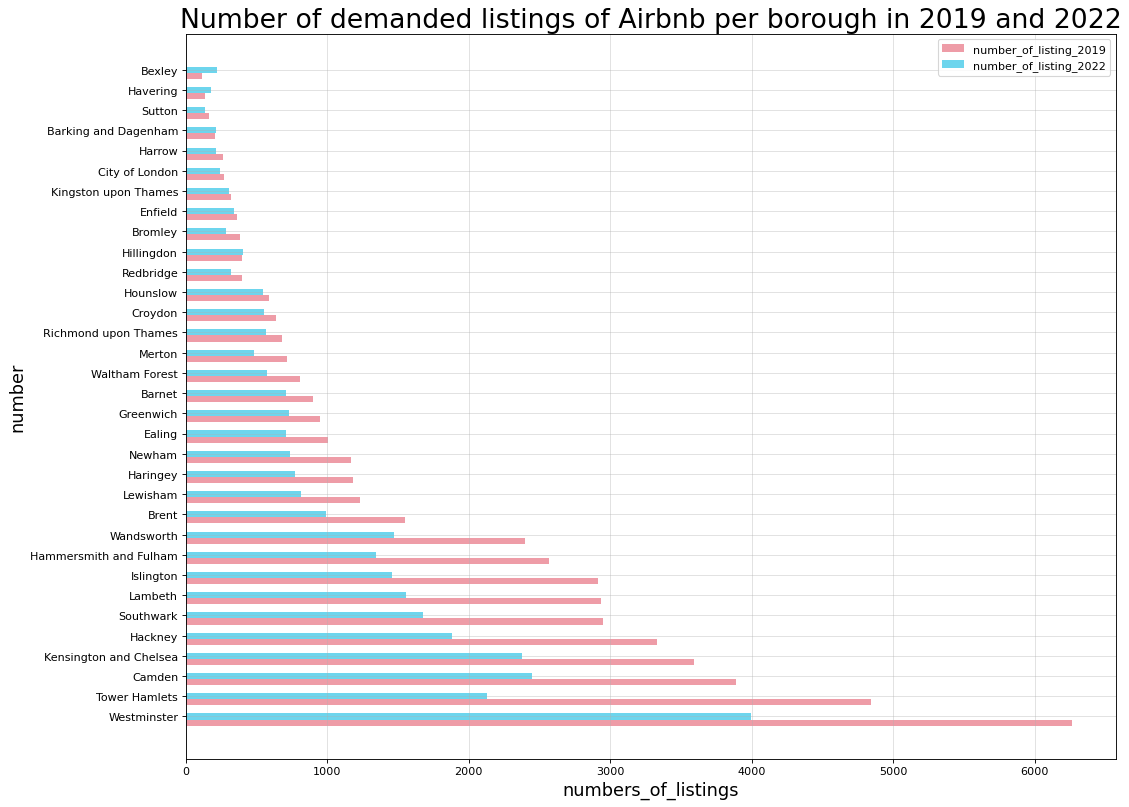

In [45]:
from matplotlib import pyplot as plt
from matplotlib import font_manager



#set figure size
plt.figure(figsize=(15,12),dpi = 80)

#set dataframes
a = demand_19_22.index.tolist()
b_1 = demand_19_22.iloc[:, 0].tolist()
b_2 = demand_19_22.iloc[:, 1].tolist()

height = 0.3
a1 = list(range(len(a)))
a2 = [i+height for i in a1]# Axis Offset
#a3 = [i+height*2 for i in a1]

#plot to check
plt.barh(range(len(a)),b_1,height= height,label = "number_of_listing_2019",color = "#ee9ca7")
plt.barh(a2,b_2,height= height,label = "number_of_listing_2022",color = "#6dd5ed")


#plot grids
plt.grid(alpha = 0.4)

# add lables in y axis 
plt.yticks(a2,a,fontsize = 10)

# add legend
plt.legend()

# add x axis lables and title
plt.xlabel("numbers_of_listings",fontsize = 16)
plt.ylabel("number",fontsize = 16)
plt.title("Number of demanded listings of Airbnb per borough in 2019 and 2022",fontsize = 24)

#plot to check
plt.show()



in the follwing part can only get the remained listings, which have the same ids in 2019 and 2022.

In [46]:
# two listings demand_19, and demand_22
print(f"There are {demand_19.shape[0]} listings in demand in 2019")
print(f"There are {demand_22.shape[0]} listings in demand in 2022.")

There are 50080 listings in demand in 2019
There are 31323 listings in demand in 2022.


There is a significant reduce in demand after the covid.

In [47]:
remain_list = pd.merge(demand_19, demand_22, how ='inner', on =['id'])

remain_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9514 entries, 0 to 9513
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     9514 non-null   int64         
 1   host_id_x              9514 non-null   int64         
 2   neighbourhood_x        9514 non-null   object        
 3   latitude_x             9514 non-null   float64       
 4   longitude_x            9514 non-null   float64       
 5   price_x                9514 non-null   int64         
 6   minimum_nights_x       9514 non-null   int64         
 7   number_of_reviews_x    9514 non-null   int64         
 8   last_review_x          9514 non-null   datetime64[ns]
 9   reviews_per_month_x    9514 non-null   float64       
 10  availability_365_x     9514 non-null   int64         
 11  host_id_y              9514 non-null   int64         
 12  neighbourhood_y        9514 non-null   object        
 13  lat

The latitude, longitude of the same id listing are not accurate, since Airbnb announced that they will not reveal the real location of the listing.

So here, we just use the newest ones as well as neighbourhood.

In [48]:
remain_list.rename(columns={'host_id_y':'host_id', 'neighbourhood_y':'neighbourhood', 
                  'latitude_y':'latitude', 'longitude_y':'longitude'}, inplace=True)

remain_list.head()

id  host_id_x       neighbourhood_x  latitude_x  longitude_x  price_x  \
0  9582415   49602995  Richmond upon Thames    51.44473     -0.37900       35   
1    42010     157884                Barnet    51.58611     -0.16272       45   
2   387835    1940607  Richmond upon Thames    51.42833     -0.34646       39   
3   350588    1775224             Islington    51.53638     -0.11896       98   
4   469187    1952786            Wandsworth    51.47386     -0.16397       56   

   minimum_nights_x  number_of_reviews_x last_review_x  reviews_per_month_x  \
0                 1                   47    2019-11-06                 2.27   
1                 2                  490    2019-11-05                 4.41   
2                 1                  140    2019-11-05                 1.51   
3                 2                  120    2019-11-05                 3.06   
4                 1                  331    2019-11-05                 3.69   

   ...         neighbourhood  latitude longitude  price_y  minimum_nights_y  \
0  ...  Richmond upon Thames  51.44521  -0.38031       39                21   
1  ...                Barnet  51.58590  -0.16434       60                 4   
2  ...  Richmond upon Thames  51.42863  -0.34688       39                 1   
3  ...             Islington  51.53555  -0.11739       75                 2   
4  ...            Wandsworth  51.47537  -0.16432       60                 1   

   number_of_reviews_y  number_of_reviews_ltm  last_review_y  \
0                   95                     36     2022-08-18   
1                  527                     17     2022-08-17   
2                  201                     35     2022-06-19   
3                  199                     51     2022-09-04   
4                  414                     46     2022-08-29   

   reviews_per_month_y availability_365_y  
0                 1.72                318  
1                 3.62                252  
2                 1.58                307  
3                 2.69                  1  
4                 3.33                289  

[5 rows x 22 columns]

Here, we notice that although we intersected the two listings with same `id` , some column values may changed over time, for example, the price.

We're going to use these `_x`, `_y` columns to generate new columns showing changes in percentages.

In [49]:
# price changes
remain_list['price_change'] = (remain_list['price_y'] - remain_list['price_x']) *100 / (remain_list['price_x'])

# minimum_nights changes
remain_list['mim_nights_change'] = (remain_list['minimum_nights_y'] - remain_list['minimum_nights_x']) *100 / (remain_list['minimum_nights_x'])

# demand change (reviews_per_month)
remain_list['demand_change'] = (remain_list['reviews_per_month_y'] - remain_list['reviews_per_month_x'])*100 / (remain_list['reviews_per_month_x'])

# availability changes
remain_list['availability_365_change'] = (remain_list['availability_365_y'] - remain_list['availability_365_x'])*100 / (remain_list['availability_365_x'])


In [50]:
remain_list.columns.tolist()

['id',
 'host_id_x',
 'neighbourhood_x',
 'latitude_x',
 'longitude_x',
 'price_x',
 'minimum_nights_x',
 'number_of_reviews_x',
 'last_review_x',
 'reviews_per_month_x',
 'availability_365_x',
 'host_id',
 'neighbourhood',
 'latitude',
 'longitude',
 'price_y',
 'minimum_nights_y',
 'number_of_reviews_y',
 'number_of_reviews_ltm',
 'last_review_y',
 'reviews_per_month_y',
 'availability_365_y',
 'price_change',
 'mim_nights_change',
 'demand_change',
 'availability_365_change']

In [51]:
# again select columns we need
select_cols = ['id', 'host_id','neighbourhood', 'latitude', 'longitude','price_change', 
               'mim_nights_change', 'demand_change', 'availability_365_change']
remain_change = remain_list.loc[:, select_cols]

remain_change.head()

id   host_id         neighbourhood  latitude  longitude  price_change  \
0  9582415  49602995  Richmond upon Thames  51.44521   -0.38031     11.428571   
1    42010    157884                Barnet  51.58590   -0.16434     33.333333   
2   387835   1940607  Richmond upon Thames  51.42863   -0.34688      0.000000   
3   350588   1775224             Islington  51.53555   -0.11739    -23.469388   
4   469187   1952786            Wandsworth  51.47537   -0.16432      7.142857   

   mim_nights_change  demand_change  availability_365_change  
0             2000.0     -24.229075                14.388489  
1              100.0     -17.913832               -22.699387  
2                0.0       4.635762                 1.655629  
3                0.0     -12.091503               -98.958333  
4                0.0      -9.756098                -3.344482

From 2019 to 2022, we can observe that some listings are facing the declined demand needs, but in the above when we considering the supply, most boroughs have increased supplies. And this could be a finding.

Before comparing the demand and supply, we are tending to get the deactivated listings and increasing listings in demmand part.

## 4. Mapping

### 4.1 loading the shapefile

In [52]:
# loading london boros
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path
ddir  = os.path.join('data','geo') # destination directory
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )

Found data/geo/Water.gpkg locally!
Found data/geo/Boroughs.gpkg locally!
Found data/geo/Greenspace.gpkg locally!


In [53]:
boros.head()

NAME   GSS_CODE   HECTARES  NONLD_AREA ONS_INNER  \
0  Kingston upon Thames  E09000021   3726.117       0.000         F   
1               Croydon  E09000008   8649.441       0.000         F   
2               Bromley  E09000006  15013.487       0.000         F   
3              Hounslow  E09000018   5658.541      60.755         F   
4                Ealing  E09000009   5554.428       0.000         F   

                                            geometry  
0  MULTIPOLYGON (((516401.600 160201.800, 516407....  
1  MULTIPOLYGON (((535009.200 159504.700, 535005....  
2  MULTIPOLYGON (((540373.600 157530.400, 540361....  
3  MULTIPOLYGON (((521975.800 178100.000, 521967....  
4  MULTIPOLYGON (((510253.500 182881.600, 510249....

In [54]:
from fiona.crs import from_string
crs = from_string("+proj=longlat +datum=WGS84 +no_defs") 
boros = boros.to_crs(crs=crs) 

In [55]:
boros.crs

<Geographic 2D CRS: +proj=longlat +datum=WGS84 +no_defs +type=crs>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [56]:
boros.head()

NAME   GSS_CODE   HECTARES  NONLD_AREA ONS_INNER  \
0  Kingston upon Thames  E09000021   3726.117       0.000         F   
1               Croydon  E09000008   8649.441       0.000         F   
2               Bromley  E09000006  15013.487       0.000         F   
3              Hounslow  E09000018   5658.541      60.755         F   
4                Ealing  E09000009   5554.428       0.000         F   

                                            geometry  
0  MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...  
1  MULTIPOLYGON (((-0.06402 51.31864, -0.06408 51...  
2  MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2...  
3  MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51...  
4  MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51...

### 4.2 geo transform

#### 4.2.1 supply and demand listings

##### 4.2.1.1 supply 2019

In [57]:
# transform the listings in 2019 first
gdf_supply_19 = gpd.GeoDataFrame(
    supply_19, geometry=gpd.points_from_xy(supply_19.longitude, supply_19.latitude))

gdf_supply_19.head()

id    host_id           neighbourhood  latitude  longitude  price  \
0   9582415   49602995    Richmond upon Thames  51.44473   -0.37900     35   
1  23013522   70374572                Hounslow  51.45867   -0.34444     19   
2  25796711   25587547  Hammersmith and Fulham  51.47398   -0.21531    103   
3  29060134   57607790              Hillingdon  51.52716   -0.44164     85   
4  30374086  228095684                  Barnet  51.59118   -0.16670     85   

   minimum_nights  number_of_reviews last_review  reviews_per_month  \
0               1                 47  2019-11-06               2.27   
1               1                131  2019-11-06               6.52   
2               7                  8  2019-11-06               0.51   
3              14                  5  2019-11-06               0.40   
4               3                 16  2019-11-06               1.52   

   availability_365                   geometry  
0               278  POINT (-0.37900 51.44473)  
1                23  POINT (-0.34444 51.45867)  
2               317  POINT (-0.21531 51.47398)  
3               346  POINT (-0.44164 51.52716)  
4               139  POINT (-0.16670 51.59118)

##### 4.2.1.2 demand 2019

In [58]:
gdf_demand_19 = gpd.GeoDataFrame(
    demand_19, geometry=gpd.points_from_xy(demand_19.longitude, demand_19.latitude))

gdf_demand_19.head()

id    host_id           neighbourhood  latitude  longitude  price  \
0   9582415   49602995    Richmond upon Thames  51.44473   -0.37900     35   
1  23013522   70374572                Hounslow  51.45867   -0.34444     19   
2  25796711   25587547  Hammersmith and Fulham  51.47398   -0.21531    103   
3  29060134   57607790              Hillingdon  51.52716   -0.44164     85   
4  30374086  228095684                  Barnet  51.59118   -0.16670     85   

   minimum_nights  number_of_reviews last_review  reviews_per_month  \
0               1                 47  2019-11-06               2.27   
1               1                131  2019-11-06               6.52   
2               7                  8  2019-11-06               0.51   
3              14                  5  2019-11-06               0.40   
4               3                 16  2019-11-06               1.52   

   availability_365                   geometry  
0               278  POINT (-0.37900 51.44473)  
1                23  POINT (-0.34444 51.45867)  
2               317  POINT (-0.21531 51.47398)  
3               346  POINT (-0.44164 51.52716)  
4               139  POINT (-0.16670 51.59118)

##### 4.2.1.3 supply 2022

In [59]:
# 2022
gdf_supply_22 = gpd.GeoDataFrame(
    supply_22, geometry=gpd.points_from_xy(supply_22.longitude, supply_22.latitude))

gdf_supply_22.head()

id  host_id           neighbourhood  latitude  longitude  price  \
0   13913    54730               Islington  51.56861   -0.11270     50   
1   15400    60302  Kensington and Chelsea  51.48780   -0.16813     75   
2  284532  1481412           Tower Hamlets  51.52851   -0.07426     90   
3  106332   264345           Tower Hamlets  51.52874   -0.05396     55   
4   17402    67564             Westminster  51.52195   -0.14094    379   

   minimum_nights  number_of_reviews  number_of_reviews_ltm last_review  \
0               1                 30                      9  2022-07-15   
1               3                 89                      0  2020-03-16   
2               5                 42                      1  2022-01-04   
3               3                 65                      0  2016-06-10   
4               4                 51                      8  2022-09-06   

   reviews_per_month  availability_365                   geometry  
0               0.20               343  POINT (-0.11270 51.56861)  
1               0.57                70  POINT (-0.16813 51.48780)  
2               0.34               222  POINT (-0.07426 51.52851)  
3               0.47                74  POINT (-0.05396 51.52874)  
4               0.36               249  POINT (-0.14094 51.52195)

##### 4.2.1.4 demand 2022

In [60]:
gdf_demand_22 = gpd.GeoDataFrame(
    demand_22, geometry=gpd.points_from_xy(demand_22.longitude, demand_22.latitude))

gdf_demand_22.head()

id  host_id  neighbourhood  latitude  longitude  price  minimum_nights  \
0   13913    54730      Islington  51.56861   -0.11270     50               1   
2  284532  1481412  Tower Hamlets  51.52851   -0.07426     90               5   
4   17402    67564    Westminster  51.52195   -0.14094    379               4   
5  107048   259088      Islington  51.52478   -0.10484    180               4   
6  107051   554519    Westminster  51.52055   -0.18317    204               2   

   number_of_reviews  number_of_reviews_ltm last_review  reviews_per_month  \
0                 30                      9  2022-07-15               0.20   
2                 42                      1  2022-01-04               0.34   
4                 51                      8  2022-09-06               0.36   
5                493                     20  2022-09-02               3.59   
6                581                     66  2022-09-02               4.26   

   availability_365                   geometry  
0               343  POINT (-0.11270 51.56861)  
2               222  POINT (-0.07426 51.52851)  
4               249  POINT (-0.14094 51.52195)  
5               236  POINT (-0.10484 51.52478)  
6               193  POINT (-0.18317 51.52055)

##### set crs epsg:27700

In [61]:
# check the crs
# gdf_supply_19.crs shows empty, there is no crs so we need to set it first.

gdf_supply_19.crs = "EPSG:27700"

# check
gdf_supply_19.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [62]:
gdf_demand_19.crs = "EPSG:27700"
gdf_demand_19.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [63]:
gdf_supply_22.crs = "EPSG:27700"
gdf_supply_22.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [64]:
gdf_demand_22.crs = "EPSG:27700"
gdf_demand_22.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

### 4.3 Map plotting

In [65]:
import geopandas
import contextily as cx # retrieve web map tiles from several sources (OpenStreetMap, Stamen)

In [66]:
# plot our first map of supply in 2019
#ax = gdf_supply_19.plot(figsize=(20, 25), alpha=0.5, edgecolor='k')

# set the zoom level of 13 as the city level and the map style
#cx.add_basemap(ax, zoom=13) 

#### 4.3.1 Supply

For supply listings, we're using **availability_365** as indicators. 

This varaible shows "The availability of the listing 365 days in the future as determined by the calendar. Note a listing may not be available because it has been booked by a guest or blocked by the host."

So we can use this to show whether listings are supplying during the year and how many days they can supply.

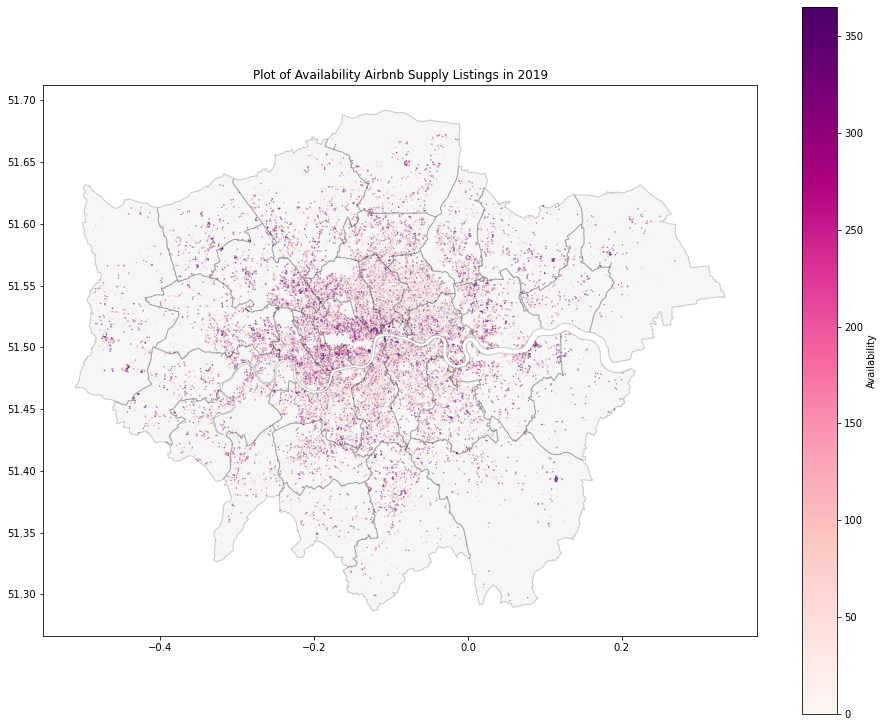

In [67]:
# first plot for supply 19, first check
ax = gdf_supply_19.plot(figsize = (16, 13), marker='.', markersize=0.4, 
         column = 'availability_365', cmap = 'RdPu', 
         legend = True, legend_kwds = {'label':'Availability'});
ax.set_title("Plot of Availability Airbnb Supply Listings in 2019");

boros.plot(ax = ax, edgecolor='black', facecolor='lightgrey', alpha=0.2);

no outliers. Then we plot the 2022 one to see if there are any changes.

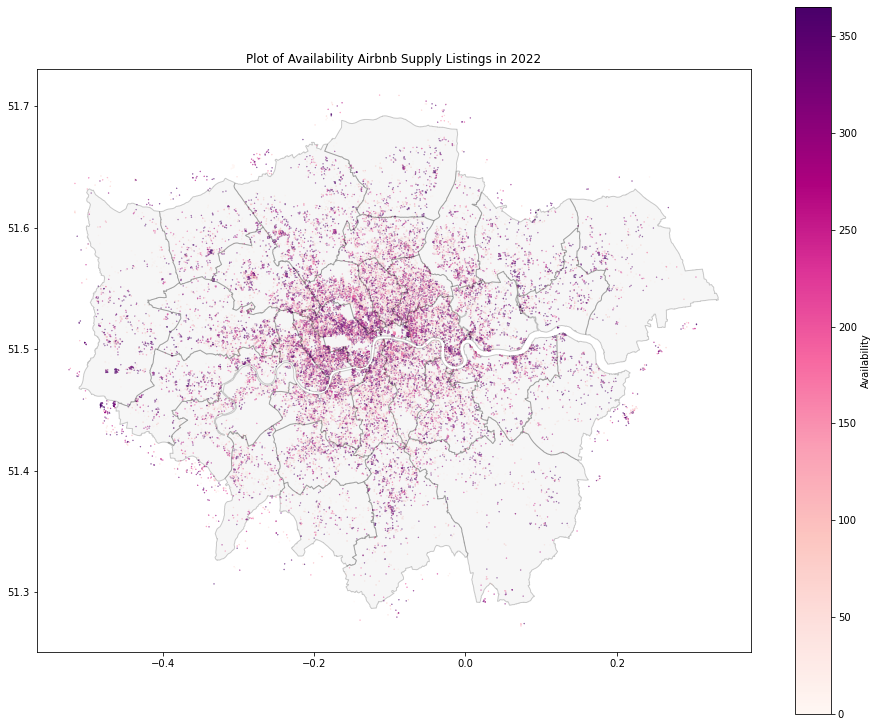

In [68]:
# plot for 2022 in supply
ax = gdf_supply_22.plot(figsize = (16, 13), marker='.', markersize=0.4, 
         column = 'availability_365', cmap = 'RdPu', 
         legend = True, legend_kwds = {'label':'Availability'});
ax.set_title("Plot of Availability Airbnb Supply Listings in 2022");

boros.plot(ax = ax, edgecolor='black', facecolor='lightgrey', alpha=0.2);

In [69]:
# a lof ot outliers in data 2022, so we need to clean the outliers.

In [70]:
# some listings are not in the area of greater London, latitude and longitude issues

# so we will set the limits for latitude and longitude.

In [71]:
gdf_supply_22 = gdf_supply_22[~gdf_supply_22.geometry.within(boros)]
gdf_supply_22

/opt/conda/lib/python3.10/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
/tmp/ipykernel_66413/2525595433.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: +proj=longlat +datum=WGS84 +no_defs +type=crs

  gdf_supply_22 = gdf_supply_22[~gdf_supply_22.geometry.within(boros)]


id    host_id           neighbourhood  latitude  \
0                   13913      54730               Islington  51.56861   
1                   15400      60302  Kensington and Chelsea  51.48780   
2                  284532    1481412           Tower Hamlets  51.52851   
3                  106332     264345           Tower Hamlets  51.52874   
4                   17402      67564             Westminster  51.52195   
...                   ...        ...                     ...       ...   
69346             9671724   49977905               Greenwich  51.48300   
69347            20277958    1132775               Southwark  51.50914   
69348            20512703    1706966    Richmond upon Thames  51.40571   
69349            49698549   34213667    Richmond upon Thames  51.41029   
69350  554172169432589107  402191311               Greenwich  51.50183   

       longitude  price  minimum_nights  number_of_reviews  \
0       -0.11270     50               1                 30   
1       -0.16813     75               3                 89   
2       -0.07426     90               5                 42   
3       -0.05396     55               3                 65   
4       -0.14094    379               4                 51   
...          ...    ...             ...                ...   
69346   -0.01346     55               5                 67   
69347   -0.10192    201               3                 61   
69348   -0.35325    246               3                  6   
69349   -0.35975    250               3                  9   
69350    0.00862    134               2                 17   

       number_of_reviews_ltm last_review  reviews_per_month  availability_365  \
0                          9  2022-07-15               0.20               343   
1                          0  2020-03-16               0.57                70   
2                          1  2022-01-04               0.34               222   
3                          0  2016-06-10               0.47                74   
4                          8  2022-09-06               0.36               249   
...                      ...         ...                ...               ...   
69346                      1  2021-10-03               0.84                 0   
69347                     12  2022-09-09               0.99                 0   
69348                      6  2022-08-31               1.49                 4   
69349                      4  2022-07-18               0.61                 2   
69350                     17  2022-06-20               2.45                85   

                    geometry  
0      POINT (-0.113 51.569)  
1      POINT (-0.168 51.488)  
2      POINT (-0.074 51.529)  
3      POINT (-0.054 51.529)  
4      POINT (-0.141 51.522)  
...                      ...  
69346  POINT (-0.013 51.483)  
69347  POINT (-0.102 51.509)  
69348  POINT (-0.353 51.406)  
69349  POINT (-0.360 51.410)  
69350   POINT (0.009 51.502)  

[69329 rows x 13 columns]

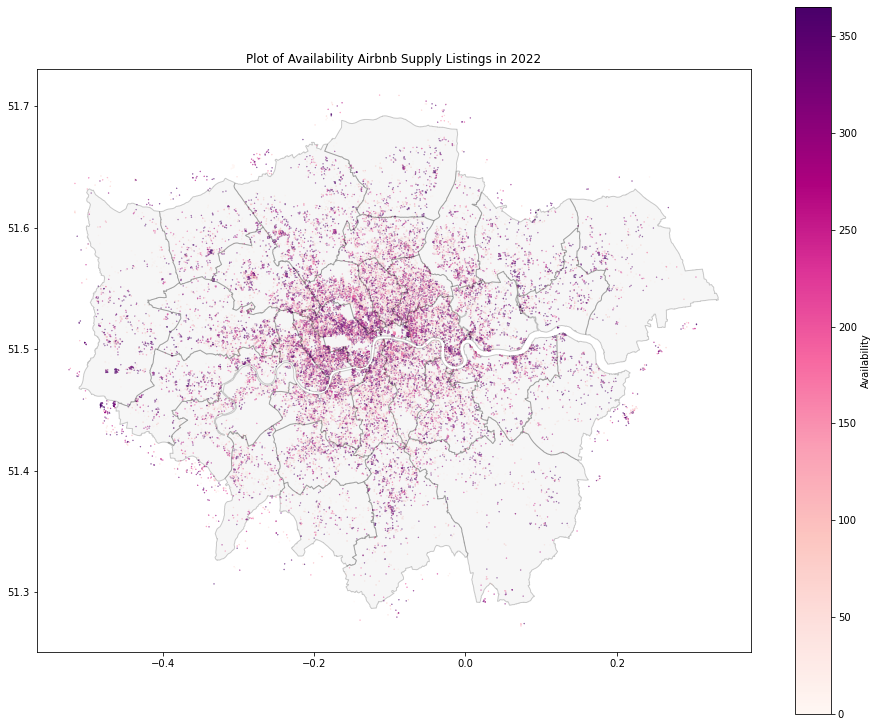

In [72]:
# plot for 2022 in supply
ax = gdf_supply_22.plot(figsize = (16, 13), marker='.', markersize=0.4, 
         column = 'availability_365', cmap = 'RdPu', 
         legend = True, legend_kwds = {'label':'Availability'});
ax.set_title("Plot of Availability Airbnb Supply Listings in 2022");

boros.plot(ax = ax, edgecolor='black', facecolor='lightgrey', alpha=0.2);

##### plot toghther

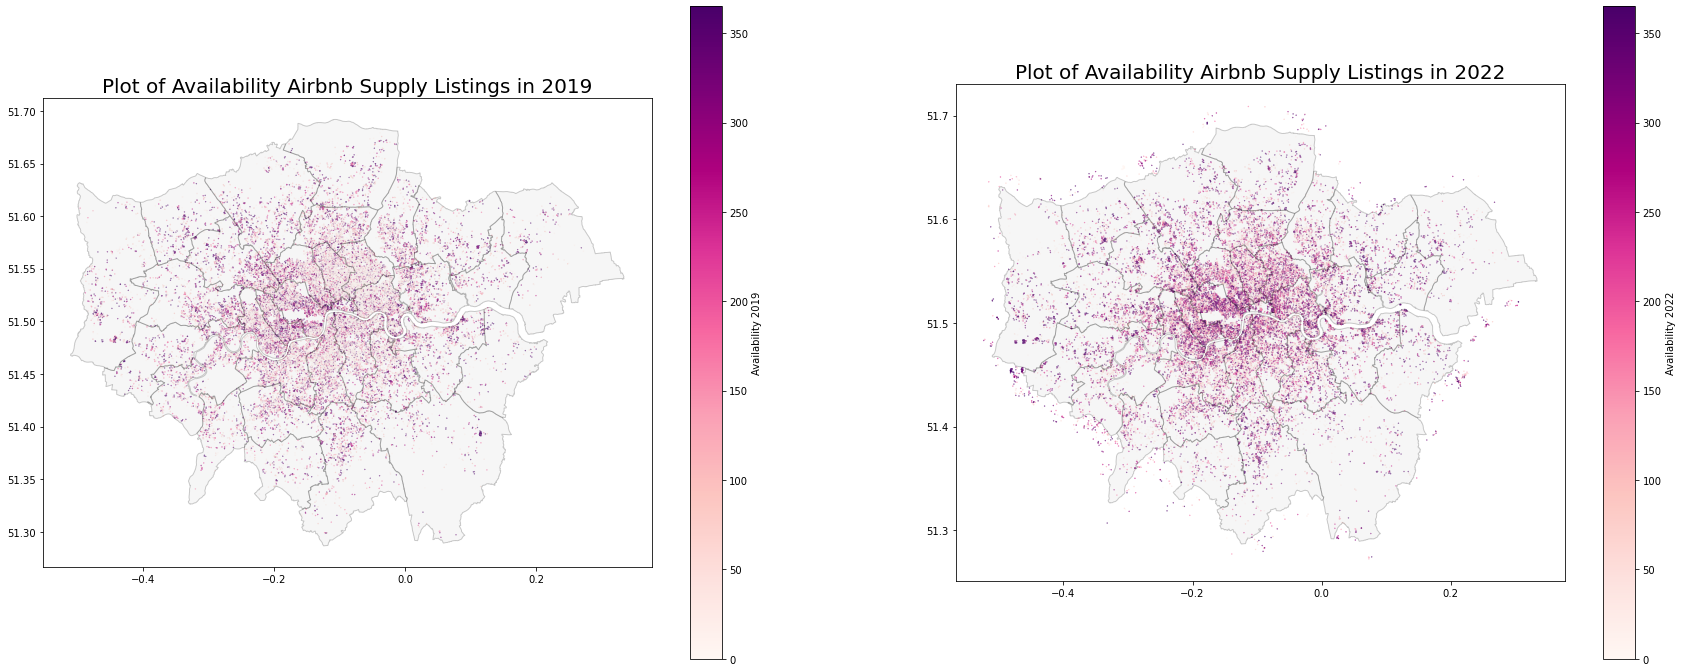

In [73]:
# plot two images together

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 40));

gdf_supply_19.plot(marker='.', markersize=0.4, 
         column = 'availability_365', cmap = 'RdPu', 
         legend = True, legend_kwds = {'label':'Availability 2019','shrink': 0.3}, ax = axes[0]);
axes[0].set_title("Plot of Availability Airbnb Supply Listings in 2019", fontsize = 20);

gdf_supply_22.plot(marker='.', markersize=0.4, 
         column = 'availability_365', cmap = 'RdPu', 
         legend = True, legend_kwds = {'label':'Availability 2022', 'shrink': 0.3}, ax = axes[1]);
axes[1].set_title("Plot of Availability Airbnb Supply Listings in 2022", fontsize = 20);


boros.plot(ax = axes[0], edgecolor='black', facecolor='lightgrey', alpha=0.2);

boros.plot(ax = axes[1], edgecolor='black', facecolor='lightgrey', alpha=0.2);



#### 4.3.2 Demand

For demanded listings, we will use **reviews_per_month** as indicators. 

This varaible shows "The number of reviews the listing has over the lifetime of the listing", can used to indicate whether the listings are required by customers.

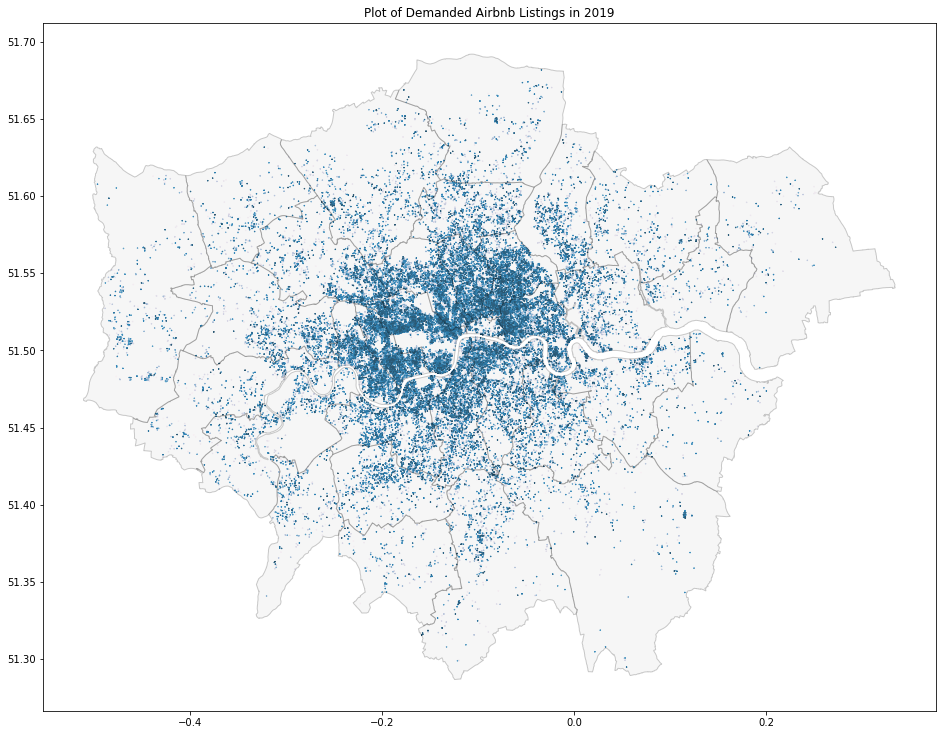

In [74]:
# first plot for demand 19, first check
ax = gdf_demand_19.plot(figsize = (16, 13), marker='*', markersize=0.5, cmap = 'PuBu', 
         legend = True, legend_kwds = {'label':'reviews'});
ax.set_title("Plot of Demanded Airbnb Listings in 2019");

boros.plot(ax = ax, edgecolor='black', facecolor='lightgrey', alpha=0.2);

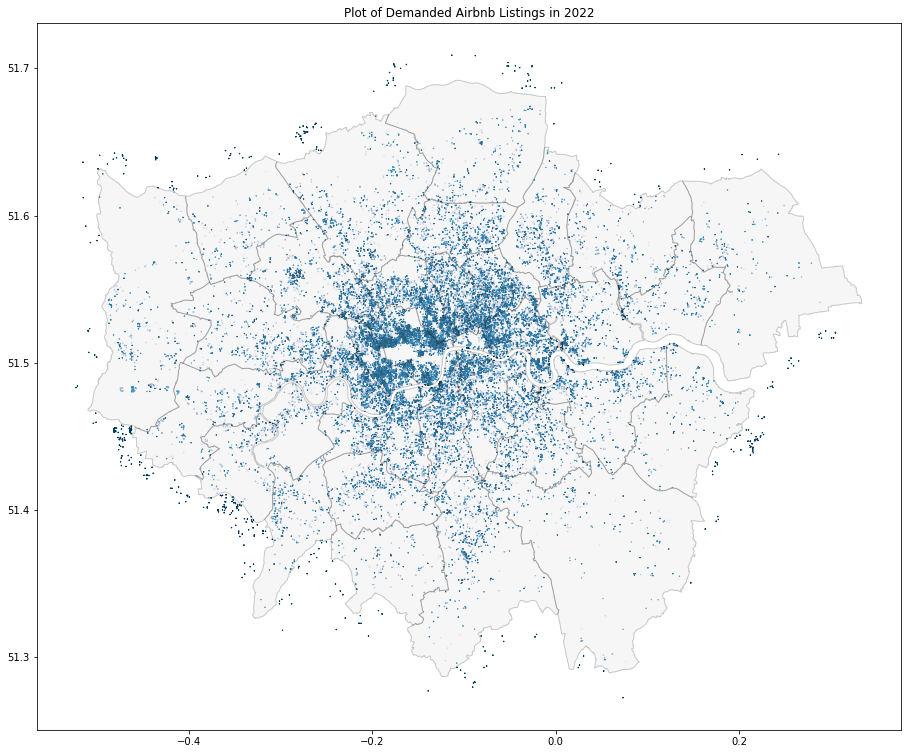

In [75]:
# demanded in 2022
ax = gdf_demand_22.plot(figsize = (16, 13), marker='*', markersize=0.4, cmap = 'PuBu', 
         legend = True, legend_kwds = {'label':'reviews'});
ax.set_title("Plot of Demanded Airbnb Listings in 2022");

boros.plot(ax = ax, edgecolor='black', facecolor='lightgrey', alpha=0.2);

In [76]:
# remove outliers

gdf_demand_22 = gdf_demand_22[~gdf_demand_22.geometry.within(boros)]
gdf_demand_22

/opt/conda/lib/python3.10/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
/tmp/ipykernel_66413/1652846066.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: +proj=longlat +datum=WGS84 +no_defs +type=crs

  gdf_demand_22 = gdf_demand_22[~gdf_demand_22.geometry.within(boros)]
/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


id    host_id         neighbourhood  latitude  \
0                   13913      54730             Islington  51.56861   
2                  284532    1481412         Tower Hamlets  51.52851   
4                   17402      67564           Westminster  51.52195   
5                  107048     259088             Islington  51.52478   
6                  107051     554519           Westminster  51.52055   
...                   ...        ...                   ...       ...   
69346             9671724   49977905             Greenwich  51.48300   
69347            20277958    1132775             Southwark  51.50914   
69348            20512703    1706966  Richmond upon Thames  51.40571   
69349            49698549   34213667  Richmond upon Thames  51.41029   
69350  554172169432589107  402191311             Greenwich  51.50183   

       longitude  price  minimum_nights  number_of_reviews  \
0       -0.11270     50               1                 30   
2       -0.07426     90               5                 42   
4       -0.14094    379               4                 51   
5       -0.10484    180               4                493   
6       -0.18317    204               2                581   
...          ...    ...             ...                ...   
69346   -0.01346     55               5                 67   
69347   -0.10192    201               3                 61   
69348   -0.35325    246               3                  6   
69349   -0.35975    250               3                  9   
69350    0.00862    134               2                 17   

       number_of_reviews_ltm last_review  reviews_per_month  availability_365  \
0                          9  2022-07-15               0.20               343   
2                          1  2022-01-04               0.34               222   
4                          8  2022-09-06               0.36               249   
5                         20  2022-09-02               3.59               236   
6                         66  2022-09-02               4.26               193   
...                      ...         ...                ...               ...   
69346                      1  2021-10-03               0.84                 0   
69347                     12  2022-09-09               0.99                 0   
69348                      6  2022-08-31               1.49                 4   
69349                      4  2022-07-18               0.61                 2   
69350                     17  2022-06-20               2.45                85   

                    geometry  
0      POINT (-0.113 51.569)  
2      POINT (-0.074 51.529)  
4      POINT (-0.141 51.522)  
5      POINT (-0.105 51.525)  
6      POINT (-0.183 51.521)  
...                      ...  
69346  POINT (-0.013 51.483)  
69347  POINT (-0.102 51.509)  
69348  POINT (-0.353 51.406)  
69349  POINT (-0.360 51.410)  
69350   POINT (0.009 51.502)  

[31322 rows x 13 columns]

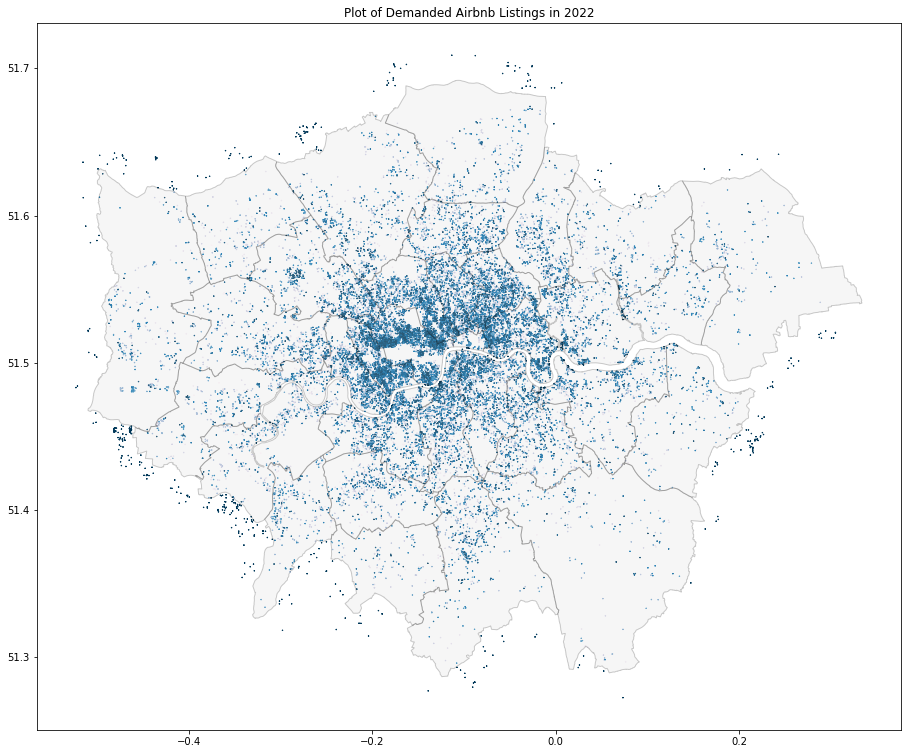

In [77]:
# plot again
ax = gdf_demand_22.plot(figsize = (16, 13), marker='*', markersize=0.4, cmap = 'PuBu', 
         legend = True, legend_kwds = {'label':'reviews'});
ax.set_title("Plot of Demanded Airbnb Listings in 2022");

boros.plot(ax = ax, edgecolor='black', facecolor='lightgrey', alpha=0.2);

##### plot toghther

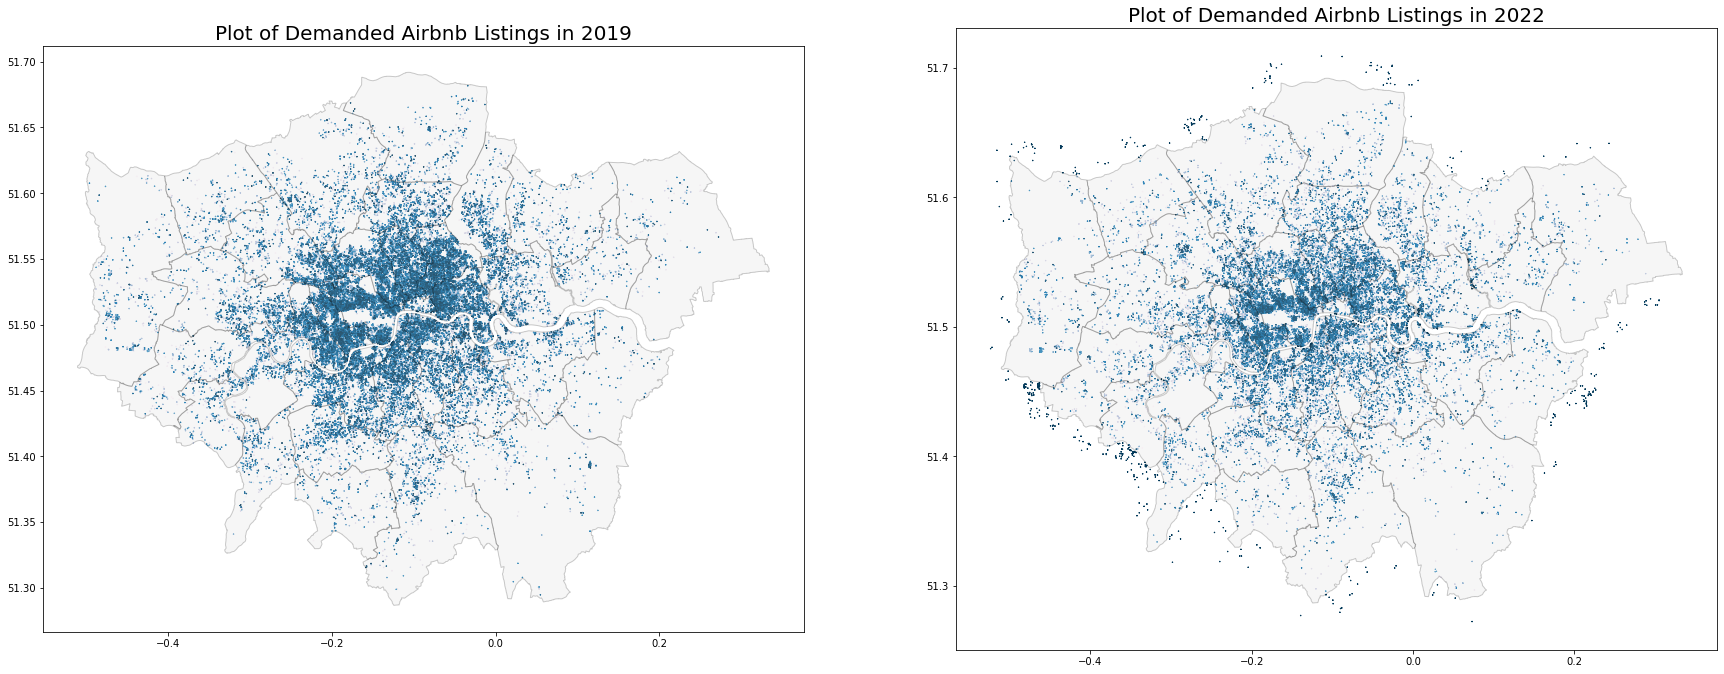

In [78]:
# plot together

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 40));


gdf_demand_19.plot(marker='*', markersize=0.5, cmap = 'PuBu', ax = axes[0]);
axes[0].set_title("Plot of Demanded Airbnb Listings in 2019",  fontsize = 20);

boros.plot(ax = axes[0], edgecolor='black', facecolor='lightgrey', alpha=0.2);


gdf_demand_22.plot(marker='*', markersize=0.4, cmap = 'PuBu', ax = axes[1]);
axes[1].set_title("Plot of Demanded Airbnb Listings in 2022",  fontsize = 20);

boros.plot(ax = axes[1], edgecolor='black', facecolor='lightgrey', alpha=0.2);

#### 4.3.3 Supply changes

use dataframes supply_19_22 and join with boros

In [79]:
# check neighbourhood column name

supply_19_22.head()

supply_19  supply_22  change_percent
neighbourhood                                               
Westminster                  7368       7760        0.050515
Tower Hamlets                6441       5591       -0.152030
Hackney                      4842       5166        0.062718
Camden                       4795       4706       -0.018912
Kensington and Chelsea       4390       4612        0.048135

In [80]:
# convert the index of neighbourhood to a new column, so we can join it with boros
supply_19_22 = supply_19_22.rename_axis('neighbourhood').reset_index()

In [81]:
supply_19_22.head()

neighbourhood  supply_19  supply_22  change_percent
0             Westminster       7368       7760        0.050515
1           Tower Hamlets       6441       5591       -0.152030
2                 Hackney       4842       5166        0.062718
3                  Camden       4795       4706       -0.018912
4  Kensington and Chelsea       4390       4612        0.048135

In [82]:
# rename columns
boros = boros.rename(columns={'NAME': 'neighbourhood'})
boros.head()

neighbourhood   GSS_CODE   HECTARES  NONLD_AREA ONS_INNER  \
0  Kingston upon Thames  E09000021   3726.117       0.000         F   
1               Croydon  E09000008   8649.441       0.000         F   
2               Bromley  E09000006  15013.487       0.000         F   
3              Hounslow  E09000018   5658.541      60.755         F   
4                Ealing  E09000009   5554.428       0.000         F   

                                            geometry  
0  MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...  
1  MULTIPOLYGON (((-0.06402 51.31864, -0.06408 51...  
2  MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2...  
3  MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51...  
4  MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51...

In [83]:
# joio two files together

gdf_supply_19_22  = supply_19_22.merge(boros, on='neighbourhood', how='left')

gdf_supply_19_22= gpd.GeoDataFrame(gdf_supply_19_22, geometry='geometry')

gdf_supply_19_22.head()

neighbourhood  supply_19  supply_22  change_percent   GSS_CODE  \
0             Westminster       7368       7760        0.050515  E09000033   
1           Tower Hamlets       6441       5591       -0.152030  E09000030   
2                 Hackney       4842       5166        0.062718  E09000012   
3                  Camden       4795       4706       -0.018912  E09000007   
4  Kensington and Chelsea       4390       4612        0.048135  E09000020   

   HECTARES  NONLD_AREA ONS_INNER  \
0  2203.005      54.308         T   
1  2157.501     179.707         T   
2  1904.902       0.000         T   
3  2178.932       0.000         T   
4  1238.379      25.994         T   

                                            geometry  
0  MULTIPOLYGON (((-0.15000 51.48548, -0.15009 51...  
1  MULTIPOLYGON (((-0.07938 51.50784, -0.07935 51...  
2  MULTIPOLYGON (((-0.09766 51.57365, -0.09756 51...  
3  MULTIPOLYGON (((-0.14242 51.56912, -0.14250 51...  
4  MULTIPOLYGON (((-0.18388 51.47742, -0.18403 51...

In [84]:
gdf_supply_19_22.crs

<Geographic 2D CRS: +proj=longlat +datum=WGS84 +no_defs +type=crs>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

##### plot

In [85]:
# plot to check

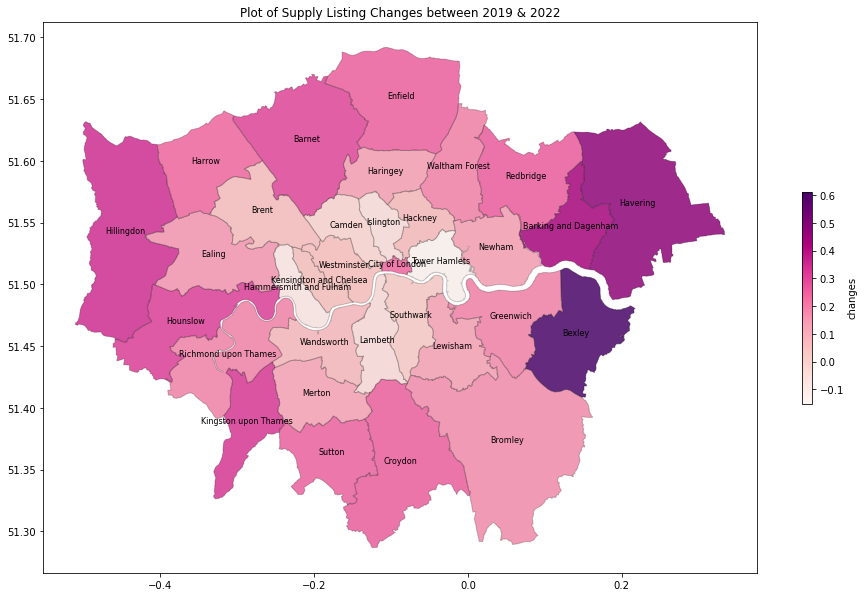

In [86]:
ax = gdf_supply_19_22.plot(figsize = (16, 13), marker='.', markersize=0.4, 
         column = 'change_percent', cmap = 'RdPu', 
                          legend = True, legend_kwds = {'label':'changes','shrink': 0.3});
ax.set_title("Plot of Supply Listing Changes between 2019 & 2022");

# plot borough names
boros.apply(lambda x: ax.annotate(text=x.neighbourhood, xy=x.geometry.centroid.coords[0], ha='center', color = "black", fontsize = 8), axis=1)

boros.plot(ax = ax, edgecolor='black', facecolor='lightgrey', alpha=0.2);

#### 4.3.4 Demand changes

In [87]:
# convert the index of neighbourhood to a new column, so we can join it with boros
demand_19_22 = demand_19_22.rename_axis('neighbourhood').reset_index()

In [88]:
demand_19_22.head()

neighbourhood  demands_19  demands_22  change_percent
0             Westminster        6262        3992       -0.568637
1           Tower Hamlets        4840        2130       -1.272300
2                  Camden        3891        2447       -0.590110
3  Kensington and Chelsea        3591        2375       -0.512000
4                 Hackney        3328        1880       -0.770213

In [89]:
# joio two files together

gdf_demand_19_22  = demand_19_22.merge(boros, on='neighbourhood', how='left')

gdf_demand_19_22= gpd.GeoDataFrame(gdf_demand_19_22, geometry='geometry')

gdf_demand_19_22.crs

<Geographic 2D CRS: +proj=longlat +datum=WGS84 +no_defs +type=crs>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [90]:
gdf_demand_19_22.head()

neighbourhood  demands_19  demands_22  change_percent   GSS_CODE  \
0             Westminster        6262        3992       -0.568637  E09000033   
1           Tower Hamlets        4840        2130       -1.272300  E09000030   
2                  Camden        3891        2447       -0.590110  E09000007   
3  Kensington and Chelsea        3591        2375       -0.512000  E09000020   
4                 Hackney        3328        1880       -0.770213  E09000012   

   HECTARES  NONLD_AREA ONS_INNER  \
0  2203.005      54.308         T   
1  2157.501     179.707         T   
2  2178.932       0.000         T   
3  1238.379      25.994         T   
4  1904.902       0.000         T   

                                            geometry  
0  MULTIPOLYGON (((-0.15000 51.48548, -0.15009 51...  
1  MULTIPOLYGON (((-0.07938 51.50784, -0.07935 51...  
2  MULTIPOLYGON (((-0.14242 51.56912, -0.14250 51...  
3  MULTIPOLYGON (((-0.18388 51.47742, -0.18403 51...  
4  MULTIPOLYGON (((-0.09766 51.57365, -0.09756 51...

##### plot

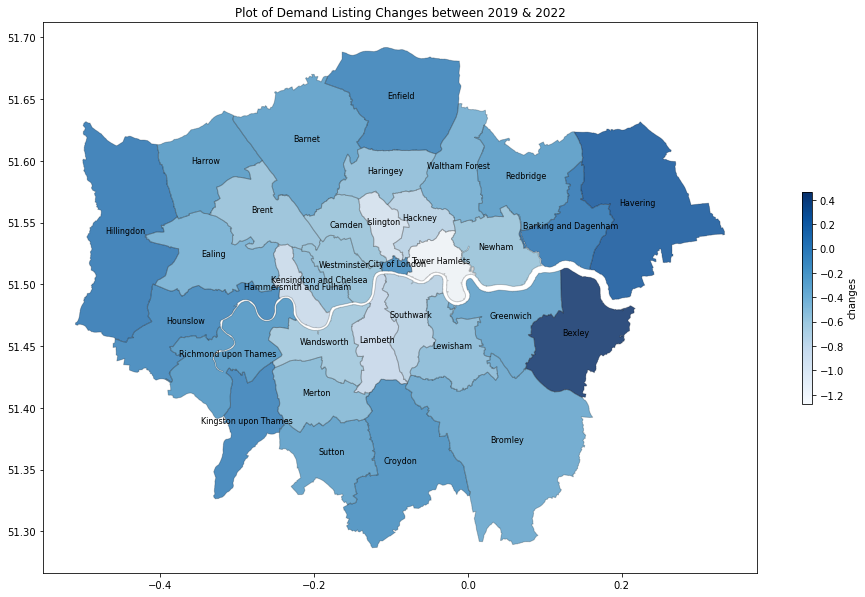

In [91]:
# plot to check
ax = gdf_demand_19_22.plot(figsize = (16, 13), marker='.', markersize=0.4, 
         column = 'change_percent', cmap = 'Blues',
                          legend = True, legend_kwds = {'label':'changes','shrink': 0.3});
ax.set_title("Plot of Demand Listing Changes between 2019 & 2022");

# plot borough names
boros.apply(lambda x: ax.annotate(text=x.neighbourhood, xy=x.geometry.centroid.coords[0], ha='center', color = "black", fontsize = 8), axis=1)

boros.plot(ax = ax, edgecolor='black', facecolor='lightgrey', alpha=0.2);

##### Supply & Demand changes (plotting together)

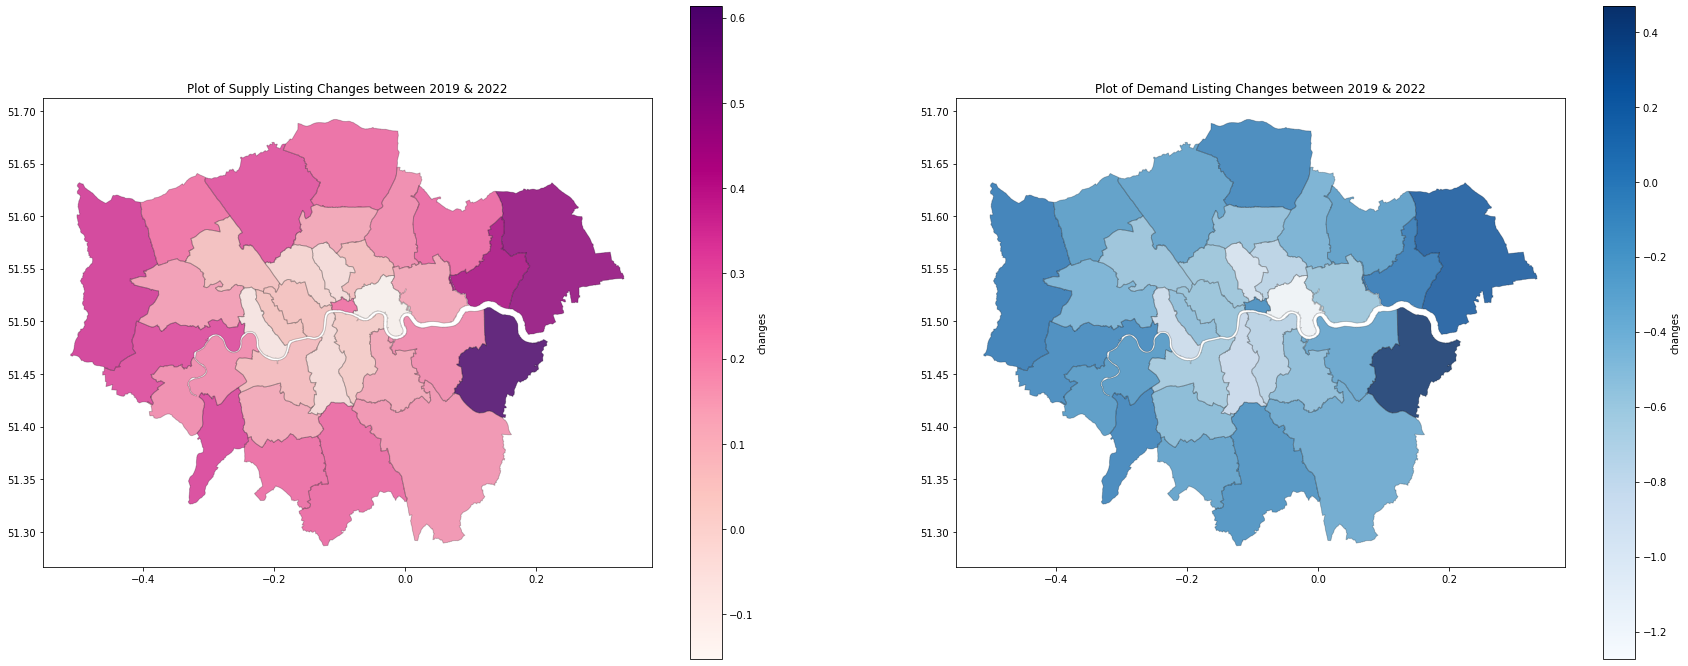

In [92]:
# plot together

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 40));


gdf_supply_19_22.plot(figsize = (16, 13), marker='.', markersize=0.4, 
         column = 'change_percent', cmap = 'RdPu', 
                          legend = True, legend_kwds = {'label':'changes','shrink': 0.3}, ax = axes[0]);
axes[0].set_title("Plot of Supply Listing Changes between 2019 & 2022");

# plot borough names
boros.apply(lambda x: ax.annotate(text=x.neighbourhood, xy=x.geometry.centroid.coords[0], ha='center', color = "black", fontsize = 7.5), axis=1)

boros.plot(ax = axes[0], edgecolor='black', facecolor='lightgrey', alpha=0.2);



gdf_demand_19_22.plot(figsize = (16, 13), marker='.', markersize=0.4, 
         column = 'change_percent', cmap = 'Blues', 
                          legend = True, legend_kwds = {'label':'changes','shrink': 0.3}, ax = axes[1]);
axes[1].set_title("Plot of Demand Listing Changes between 2019 & 2022");

# plot borough names
boros.apply(lambda x: ax.annotate(text=x.neighbourhood, xy=x.geometry.centroid.coords[0], ha='center', color = "black", fontsize = 7.5), axis=1)


boros.plot(ax = axes[1], edgecolor='black', facecolor='lightgrey', alpha=0.2);